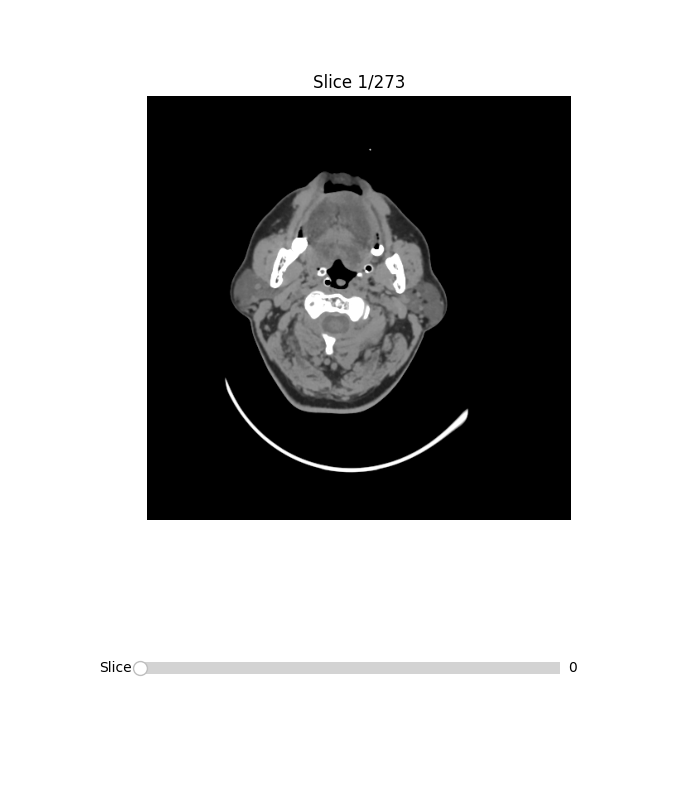

In [2]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from glob import glob
from matplotlib.widgets import Slider

# Enable interactive mode for VSCode (fixes layout issues)
%matplotlib widget  

class SimpleDicomViewer:
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.slices = []
        self.hu_data = []
        self.current_index = 0
        self.window_center = 40
        self.window_width = 400

        # Create a separate figure with larger size to accommodate slider
        self.fig, self.ax = plt.subplots(figsize=(7, 8))  
        plt.subplots_adjust(bottom=0.35)  # Allocate space for slider outside image

    def load_dicom_series(self):
        """Load all DICOM files from the specified folder."""
        dicom_files = sorted(glob(os.path.join(self.folder_path, "*.dcm")))
        if not dicom_files:
            print(f"No DICOM files found in {self.folder_path}")
            return False

        self.slices = [pydicom.dcmread(file) for file in dicom_files]

        # Convert to Hounsfield Units (HU)
        self.hu_data = []
        for s in self.slices:
            pixel_array = s.pixel_array.astype(np.float32)
            if hasattr(s, 'RescaleSlope') and hasattr(s, 'RescaleIntercept'):
                pixel_array = pixel_array * float(s.RescaleSlope) + float(s.RescaleIntercept)
            self.hu_data.append(pixel_array)

        return True

    def apply_window(self, image):
        """Apply windowing to the image."""
        min_value = self.window_center - self.window_width // 2
        max_value = self.window_center + self.window_width // 2
        windowed = np.clip(image, min_value, max_value)
        return (windowed - min_value) / (max_value - min_value)

    def display_image(self, index):
        """Display the given slice index."""
        self.ax.clear()
        self.ax.imshow(self.apply_window(self.hu_data[index]), cmap='gray')
        self.ax.set_title(f"Slice {index + 1}/{len(self.hu_data)}")
        self.ax.axis('off')
        self.fig.canvas.draw()

    def update_slice(self, val):
        """Update slice when slider is moved."""
        self.current_index = int(self.slider.val)  # Get current slider position
        self.display_image(self.current_index)

    def start(self):
        """Start the viewer with a horizontal slider."""
        self.display_image(self.current_index)

        # Define separate area for slider below the image
        ax_slider = plt.axes([0.2, 0.15, 0.6, 0.03])  # Place outside image
        self.slider = Slider(ax_slider, 'Slice', 0, len(self.hu_data) - 1, valinit=0, valstep=1)
        
        # Attach the slider update function
        self.slider.on_changed(self.update_slice)

        plt.show()

# Example Usage
folder_path = "244349529 AnonymousPatient/SCMC2023051387 CT Scan Brain Plain/CT Thin Plain"
viewer = SimpleDicomViewer(folder_path)

if viewer.load_dicom_series():
    viewer.start()

In [ ]:
import json

def modify_json(file_path):
    # Read the JSON file
    with open(file_path, 'r') as file:
        data = json.load(file)

    # Ensure it's a list of dictionaries
    if not isinstance(data, list):
        raise ValueError("JSON file must contain an array of objects")

    # Modify each object in the array
    for obj in data:
        if all(key in obj for key in ["is_hemorrhage", "type", "supporting_text"]):
            obj["hemorrhage"] = {
                "is_hemorrhage": obj.pop("is_hemorrhage"),
                "type": obj.pop("type"),
                "supporting_text": obj.pop("supporting_text")
            }

    # Write the modified JSON back to the file
    with open(file_path, 'w') as file:
        json.dump(data, file, indent=4)

# Example usage
modify_json("data/hemorrhage_brain_ct.json")

In [5]:
import json

def reformat_json(input_file, output_file, indent=4):
    """Reads a JSON file, reformats it with proper indentation, and saves it."""
    try:
        with open(input_file, "r", encoding="utf-8") as file:
            data = json.load(file)  # Load JSON content

        with open(output_file, "w", encoding="utf-8") as file:
            json.dump(data, file, indent=indent, ensure_ascii=False)  # Save formatted JSON

        print(f"✅ Reformatted JSON saved to: {output_file}")

    except json.JSONDecodeError as e:
        print(f"❌ JSON formatting error: {e}")
    except Exception as e:
        print(f"❌ An error occurred: {e}")

# Example usage
input_file = "data/hemorrhage_brain_ct.json"  # Replace with your file name
output_file = "data/hemorrhage_brain_ct.json"
reformat_json(input_file, output_file)

✅ Reformatted JSON saved to: data/hemorrhage_brain_ct.json


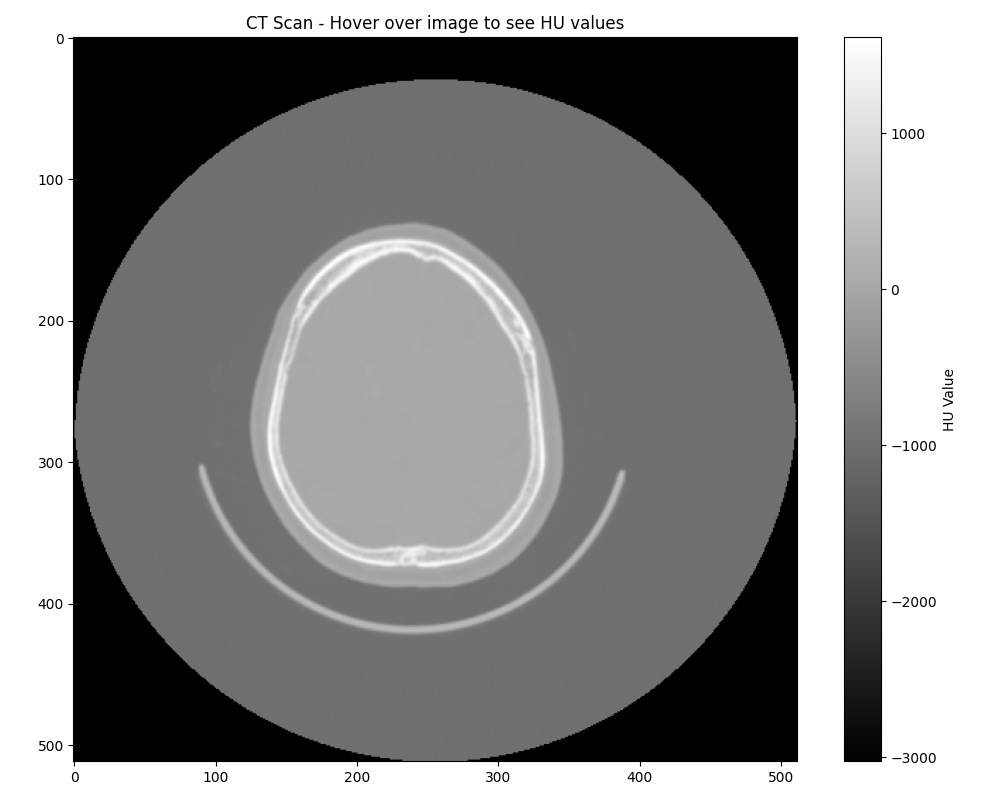

In [23]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor

# Load the DICOM file
dicom_file = pydicom.dcmread("244349529 AnonymousPatient/SCMC2023051387 CT Scan Brain Plain/CT Thin Plain/CT000225.dcm")

# Get pixel data
pixel_array = dicom_file.pixel_array

# Convert to HU
rescale_intercept = dicom_file.RescaleIntercept
rescale_slope = dicom_file.RescaleSlope
hu_image = pixel_array * rescale_slope + rescale_intercept

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Display the image
im = ax.imshow(hu_image, cmap='gray')
plt.colorbar(im, label='HU Value')
plt.title('CT Scan - Hover over image to see HU values')

# Add text annotation that will be updated
hu_text = ax.text(0.02, 0.02, '', transform=ax.transAxes, 
                  bbox=dict(facecolor='white', alpha=0.8))

# Function to handle mouse movement
def on_mouse_move(event):
    if event.inaxes:
        col = int(round(event.xdata))
        row = int(round(event.ydata))
        if 0 <= row < hu_image.shape[0] and 0 <= col < hu_image.shape[1]:
            value = hu_image[row, col]
            hu_text.set_text(f'Position: ({col}, {row})\nHU Value: {value:.1f}')
            fig.canvas.draw_idle()

# Connect the motion event
fig.canvas.mpl_connect('motion_notify_event', on_mouse_move)

# Add a cursor to make it easier to see which pixel is being examined
cursor = Cursor(ax, useblit=True, color='red', linewidth=1)

plt.tight_layout()
plt.show()

Loading DICOM files...
Found 273 slices. Creating 3D volume...
Volume shape: (273, 512, 512)
Pixel spacing: 0.625000mm x 0.625000mm
Slice thickness: 0.625mm
Generating multiplanar reconstructions...
MPR views saved to 244349529 AnonymousPatient/SCMC2023051387 CT Scan Brain Plain/CT Thin Plain Python
Launching interactive MPR viewer...


/var/folders/sl/fp5vw2q94vj7787lwp_k0j940000gn/T/ipykernel_15800/2763574128.py:246: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


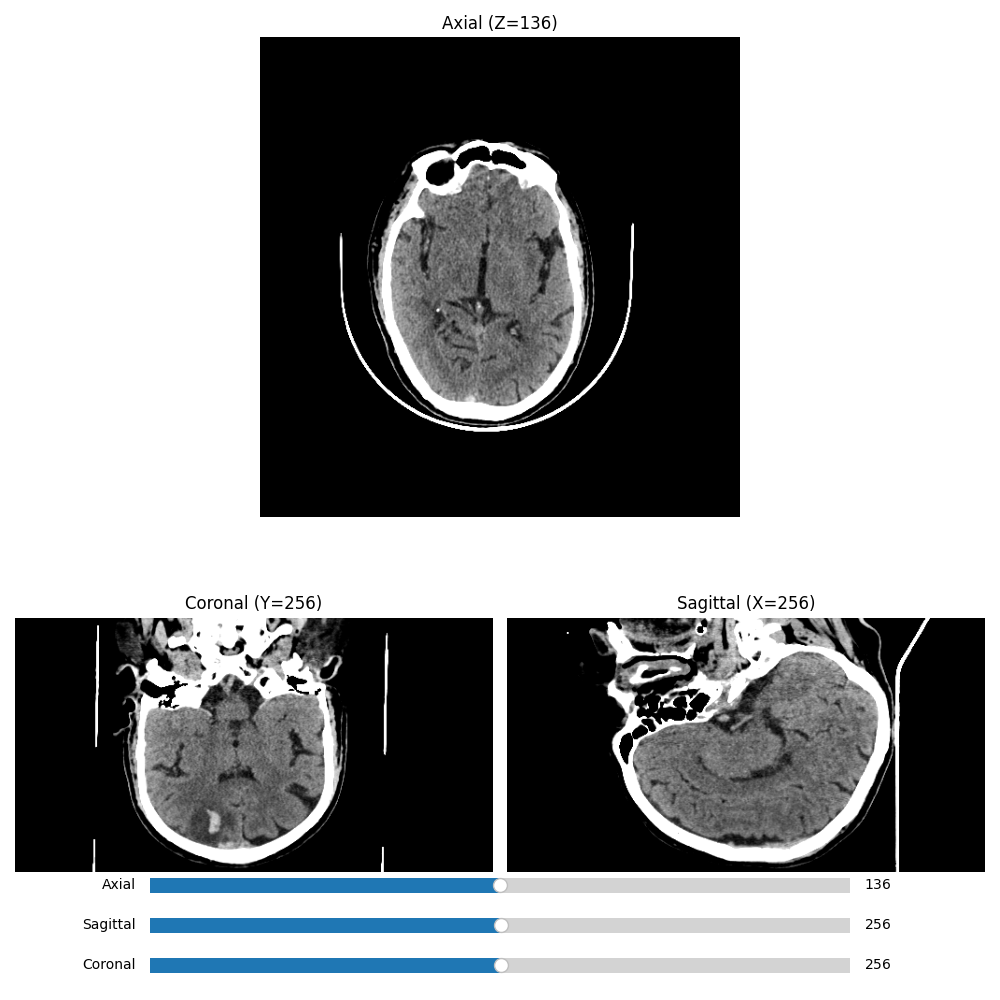

In [14]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def load_scan(path):
    """
    Load all DICOM files from a directory and sort them by slice location
    """
    # Find all DICOM files in the specified directory
    dicom_files = list(Path(path).glob('*.dcm'))
    
    # Read all files as DICOM objects
    slices = [pydicom.dcmread(str(dcm)) for dcm in dicom_files]
    
    # Sort slices based on their z-position (ImagePositionPatient)
    try:
        slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    except:
        # If ImagePositionPatient tag is not available, try to sort by SliceLocation
        try:
            slices.sort(key=lambda x: float(x.SliceLocation))
        except:
            # If SliceLocation is also not available, try InstanceNumber as last resort
            print("WARNING: Using InstanceNumber for sorting, which may not be anatomically correct")
            slices.sort(key=lambda x: int(x.InstanceNumber))
    
    return slices

def get_pixels_hu(scans):
    """
    Convert the pixel values to Hounsfield Units (HU)
    """
    images = np.stack([s.pixel_array for s in scans])
    
    # Convert to int16 to avoid overflow errors during conversion
    images = images.astype(np.int16)
    
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    images[images == -2000] = 0
    
    # Apply the DICOM RescaleSlope and RescaleIntercept
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        images = slope * images.astype(np.float64)
        images = images.astype(np.int16)
        
    images += np.int16(intercept)
    
    return images

def create_3d_volume(slices):
    """
    Create a 3D volume from the sorted DICOM slices
    """
    # Get slice thicknesses
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = slices[0].SliceThickness
    
    # Get pixel spacing (in-plane resolution)
    pixel_spacing = slices[0].PixelSpacing
    
    # Create a 3D numpy array with voxel values in HU
    img_shape = list(slices[0].pixel_array.shape)
    img_shape.append(len(slices))
    
    # Convert the stack to HU
    volume3d = get_pixels_hu(slices)
    
    # Transpose to get [z, y, x] orientation for easier slicing
    volume3d = np.transpose(volume3d, (0, 1, 2))
    
    return volume3d, pixel_spacing, slice_thickness

def generate_mpr_views(volume3d, output_path):
    """
    Generate and save multiplanar reconstructions (axial, sagittal, coronal views)
    """
    # Get dimensions
    depth, height, width = volume3d.shape
    
    # Select central slices for each view
    axial_center = depth // 2
    sagittal_center = width // 2
    coronal_center = height // 2
    
    # Extract the central slices
    axial_slice = volume3d[axial_center, :, :]
    sagittal_slice = volume3d[:, :, sagittal_center]
    coronal_slice = volume3d[:, coronal_center, :]
    
    # Window level settings (typical for brain CT)
    window_center = 40
    window_width = 80
    
    # Apply window/level
    def apply_window(image, center, width):
        img_min = center - width // 2
        img_max = center + width // 2
        windowed = np.clip(image, img_min, img_max)
        # Normalize to 0-1 range for display
        windowed = (windowed - img_min) / (img_max - img_min)
        return windowed
    
    # Apply windowing
    axial_windowed = apply_window(axial_slice, window_center, window_width)
    sagittal_windowed = apply_window(sagittal_slice, window_center, window_width)
    coronal_windowed = apply_window(coronal_slice, window_center, window_width)
    
    # Save individual views
    os.makedirs(output_path, exist_ok=True)
    
    # Create a figure with a custom grid layout (axial on top, coronal and sagittal below)
    fig = plt.figure(figsize=(10, 10))
    
    # Create a GridSpec layout with 2 rows and 2 columns
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])
    
    # Axial view on top spanning both columns
    ax_axial = fig.add_subplot(gs[0, :])
    ax_axial.imshow(axial_windowed, cmap='gray')
    ax_axial.set_title(f'Axial (Z={axial_center})')
    ax_axial.axis('off')
    
    # Coronal view on bottom left
    ax_coronal = fig.add_subplot(gs[1, 0])
    ax_coronal.imshow(coronal_windowed, cmap='gray')
    ax_coronal.set_title(f'Coronal (Y={coronal_center})')
    ax_coronal.axis('off')
    
    # Sagittal view on bottom right
    ax_sagittal = fig.add_subplot(gs[1, 1])
    ax_sagittal.imshow(sagittal_windowed, cmap='gray')
    ax_sagittal.set_title(f'Sagittal (X={sagittal_center})')
    ax_sagittal.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'mpr_views.png'), dpi=300)
    plt.close()
    
    return axial_windowed, sagittal_windowed, coronal_windowed

def interactive_mpr_viewer(volume3d):
    """
    Create an interactive MPR viewer with sliders for each view
    """
    from matplotlib.widgets import Slider
    
    # Get dimensions
    depth, height, width = volume3d.shape
    
    # Create figure with a custom grid layout
    fig = plt.figure(figsize=(10, 10))
    plt.subplots_adjust(bottom=0.25)
    
    # Create a GridSpec layout with 2 rows and 2 columns
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])
    
    # Initial positions
    axial_pos = depth // 2
    sagittal_pos = width // 2
    coronal_pos = height // 2
    
    # Window level settings
    window_center = 40
    window_width = 80
    
    # Apply window/level
    def apply_window(image, center, width):
        img_min = center - width // 2
        img_max = center + width // 2
        windowed = np.clip(image, img_min, img_max)
        windowed = (windowed - img_min) / (img_max - img_min)
        return windowed
    
    # Initial slices
    axial_slice = volume3d[axial_pos, :, :]
    sagittal_slice = volume3d[:, :, sagittal_pos]
    coronal_slice = volume3d[:, coronal_pos, :]
    
    # Apply windowing
    axial_windowed = apply_window(axial_slice, window_center, window_width)
    sagittal_windowed = apply_window(sagittal_slice, window_center, window_width)
    coronal_windowed = apply_window(coronal_slice, window_center, window_width)
    
    # Create axes with the custom layout
    ax_axial_obj = fig.add_subplot(gs[0, :])
    ax_coronal_obj = fig.add_subplot(gs[1, 0])
    ax_sagittal_obj = fig.add_subplot(gs[1, 1])
    
    # Display initial images
    ax_axial = ax_axial_obj.imshow(axial_windowed, cmap='gray')
    ax_axial_obj.set_title(f'Axial (Z={axial_pos})')
    ax_axial_obj.axis('off')
    
    ax_coronal = ax_coronal_obj.imshow(coronal_windowed, cmap='gray')
    ax_coronal_obj.set_title(f'Coronal (Y={coronal_pos})')
    ax_coronal_obj.axis('off')
    
    ax_sagittal = ax_sagittal_obj.imshow(sagittal_windowed, cmap='gray')
    ax_sagittal_obj.set_title(f'Sagittal (X={sagittal_pos})')
    ax_sagittal_obj.axis('off')
    
    # Create sliders
    ax_slider_axial = plt.axes([0.15, 0.1, 0.7, 0.03])
    ax_slider_sagittal = plt.axes([0.15, 0.06, 0.7, 0.03])
    ax_slider_coronal = plt.axes([0.15, 0.02, 0.7, 0.03])
    
    slider_axial = Slider(ax_slider_axial, 'Axial', 0, depth-1, valinit=axial_pos, valstep=1)
    slider_sagittal = Slider(ax_slider_sagittal, 'Sagittal', 0, width-1, valinit=sagittal_pos, valstep=1)
    slider_coronal = Slider(ax_slider_coronal, 'Coronal', 0, height-1, valinit=coronal_pos, valstep=1)
    
    # Update functions
    def update_axial(val):
        pos = int(slider_axial.val)
        ax_axial_obj.set_title(f'Axial (Z={pos})')
        new_slice = volume3d[pos, :, :]
        ax_axial.set_data(apply_window(new_slice, window_center, window_width))
        fig.canvas.draw_idle()
    
    def update_sagittal(val):
        pos = int(slider_sagittal.val)
        ax_sagittal_obj.set_title(f'Sagittal (X={pos})')
        new_slice = volume3d[:, :, pos]
        ax_sagittal.set_data(apply_window(new_slice, window_center, window_width))
        fig.canvas.draw_idle()
    
    def update_coronal(val):
        pos = int(slider_coronal.val)
        ax_coronal_obj.set_title(f'Coronal (Y={pos})')
        new_slice = volume3d[:, pos, :]
        ax_coronal.set_data(apply_window(new_slice, window_center, window_width))
        fig.canvas.draw_idle()
    
    # Register update functions with sliders
    slider_axial.on_changed(update_axial)
    slider_sagittal.on_changed(update_sagittal)
    slider_coronal.on_changed(update_coronal)
    
    plt.tight_layout()
    plt.show()

def main():
    # Input and output directories
    input_dir = "244349529 AnonymousPatient/SCMC2023051387 CT Scan Brain Plain/CT Thin Plain"  # Change this to your DICOM folder
    output_dir = "244349529 AnonymousPatient/SCMC2023051387 CT Scan Brain Plain/CT Thin Plain Python"     # Change this to your output folder
    
    print("Loading DICOM files...")
    slices = load_scan(input_dir)
    
    print(f"Found {len(slices)} slices. Creating 3D volume...")
    volume3d, pixel_spacing, slice_thickness = create_3d_volume(slices)
    
    print(f"Volume shape: {volume3d.shape}")
    print(f"Pixel spacing: {pixel_spacing[0]}mm x {pixel_spacing[1]}mm")
    print(f"Slice thickness: {slice_thickness}mm")
    
    # Generate and save static MPR views
    print("Generating multiplanar reconstructions...")
    axial, sagittal, coronal = generate_mpr_views(volume3d, output_dir)
    print(f"MPR views saved to {output_dir}")
    
    # Launch interactive viewer
    print("Launching interactive MPR viewer...")
    interactive_mpr_viewer(volume3d)

if __name__ == "__main__":
    main()

In [43]:
import os
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import numpy as np
import cv2

def dicom_to_hu_png(dicom_path, png_path):
    """
    Converts a DICOM image to Hounsfield Unit (HU) values and saves as PNG.

    Args:
        dicom_path (str): Path to the DICOM file.
        png_path (str): Path to save the PNG file.
    """
    try:
        dicom = pydicom.dcmread(dicom_path)

        if 'PixelData' not in dicom:
            print(f"Error: No pixel data found in DICOM file: {dicom_path}")
            return

        pixel_array = dicom.pixel_array

        # Convert to HU
        if 'RescaleIntercept' in dicom and 'RescaleSlope' in dicom:
            intercept = dicom.RescaleIntercept
            slope = dicom.RescaleSlope
            hu_array = pixel_array * slope + intercept
        else:
            print(f"Warning: RescaleIntercept or RescaleSlope missing in {dicom_path}. Using raw pixel values.")
            hu_array = pixel_array

        # Windowing (optional, adjust window width and level as needed)
        if 'WindowWidth' in dicom and 'WindowCenter' in dicom:
            hu_array = apply_voi_lut(hu_array, dicom)
        else:
            print(f"Warning: WindowWidth or WindowCenter missing in {dicom_path}. No windowing applied.")

        # Normalize to 0-255 for PNG
        min_hu = np.min(hu_array)
        max_hu = np.max(hu_array)

        if max_hu - min_hu != 0:
            normalized_array = ((hu_array - min_hu) / (max_hu - min_hu)) * 255.0
            normalized_array = np.uint8(normalized_array)
        else:
            normalized_array = np.uint8(np.zeros_like(hu_array))

        cv2.imwrite(png_path, normalized_array)
        print(f"Converted {dicom_path} to HU PNG: {png_path}")

    except Exception as e:
        print(f"Error processing {dicom_path}: {e}")

# Example usage (replace with your DICOM and PNG paths):
dicom_folder = "247326361 AnonymousPatient/SCMC20230510165 CT Scan Brain Plain/CT 5mm Plain"  # Replace with your DICOM folder
png_folder = "CT Images PNG"  # Replace with your PNG folder

if not os.path.exists(png_folder):
    os.makedirs(png_folder)

dicom_files = []
for filename in os.listdir(dicom_folder):
    if filename.endswith(".dcm") or filename.endswith(".dicom"):
        dicom_files.append(os.path.join(dicom_folder, filename))

# Sort DICOM files by InstanceNumber
dicom_files.sort(key=lambda x: pydicom.dcmread(x).get('InstanceNumber', float('inf'))) #inf handles missing InstanceNumber
patient_id = dicom_folder.split()[0]  # Extract the first part as patient ID

for dicom_file in dicom_files:
    try:
        dicom = pydicom.dcmread(dicom_file)
        instance_number = dicom.get('InstanceNumber', "unknown") #handles missing InstanceNumber

        if instance_number == "unknown":
            png_file = os.path.join(png_folder, os.path.basename(dicom_file).replace(".dcm", ".png").replace(".dicom", ".png"))
        else:
            png_file = os.path.join(png_folder, f"{patient_id}_{instance_number}.png")

        dicom_to_hu_png(dicom_file, png_file)
    except Exception as e:
        print(f"Error processing {dicom_file}: {e}")

Converted 247326361 AnonymousPatient/SCMC20230510165 CT Scan Brain Plain/CT 5mm Plain/CT000026.dcm to HU PNG: CT Images PNG/247326361_1.png
Converted 247326361 AnonymousPatient/SCMC20230510165 CT Scan Brain Plain/CT 5mm Plain/CT000025.dcm to HU PNG: CT Images PNG/247326361_2.png
Converted 247326361 AnonymousPatient/SCMC20230510165 CT Scan Brain Plain/CT 5mm Plain/CT000024.dcm to HU PNG: CT Images PNG/247326361_3.png
Converted 247326361 AnonymousPatient/SCMC20230510165 CT Scan Brain Plain/CT 5mm Plain/CT000023.dcm to HU PNG: CT Images PNG/247326361_4.png
Converted 247326361 AnonymousPatient/SCMC20230510165 CT Scan Brain Plain/CT 5mm Plain/CT000022.dcm to HU PNG: CT Images PNG/247326361_5.png
Converted 247326361 AnonymousPatient/SCMC20230510165 CT Scan Brain Plain/CT 5mm Plain/CT000021.dcm to HU PNG: CT Images PNG/247326361_6.png
Converted 247326361 AnonymousPatient/SCMC20230510165 CT Scan Brain Plain/CT 5mm Plain/CT000020.dcm to HU PNG: CT Images PNG/247326361_7.png
Converted 247326361 

In [44]:
import json

with open('data/hemorrhage_brain_ct.json', 'r') as file:
    data = json.load(file)

# Initialize counters
count_true = sum(entry.get("hemorrhage", {}).get("is_hemorrhage", False) for entry in data)
count_false = len(data) - count_true

print(f"Count of is_hemorrhage = true: {count_true}")
print(f"Count of is_hemorrhage = false: {count_false}")

Count of is_hemorrhage = true: 233
Count of is_hemorrhage = false: 452


In [8]:
import pandas as pd

def extract_hemorrhage_patient_ids(input_csv, output_csv):
    # Read the CSV into a DataFrame
    df = pd.read_csv(input_csv)

    # Make sure column names are lowercased
    df.columns = [col.lower() for col in df.columns]

    # Normalize the type column to lowercase for case-insensitive matching
    df['type'] = df['type'].str.lower()

    # Keywords to match
    keywords = ['intracranial', 'intraventricular', 'subarachnoid']

    # Filter rows where any of the keywords are present in the 'type' column
    mask = df['type'].apply(lambda x: any(keyword in x for keyword in keywords))
    filtered_df = df[mask]

    # Extract and save only the patient_id column
    filtered_df[['patient id']].to_csv(output_csv, index=False)

    print(f"Extracted {len(filtered_df)} matching patient IDs to {output_csv}")

# Example usage:
extract_hemorrhage_patient_ids("data/brain_hemorrhage_ct - instances.csv", "data/intraparanchymal_intraventricular_subarachnoid_patient_ids.csv")

Extracted 119 matching patient IDs to data/intraparanchymal_intraventricular_subarachnoid_patient_ids.csv


Step 1 & 2: Finding co-occurrence images and extracting patient IDs...
Found 681 label files in data/roboflow_dataset/train/labels.


Scanning Labels:   0%|          | 0/681 [00:00<?, ?it/s]

Found 9 images with co-occurrence of class 1 and 2.
Extracted 1 unique patient IDs: ['309904265']

Step 3: Locating relevant axial image files (JPG/PNG)...


Finding Images:   0%|          | 0/1 [00:00<?, ?it/s]

  Found 139 image files in data/intraparenchymal_intraventricular_subarachnoid_images/309904265/309904265 AnonymousPatient_SCMC2023118019 CT Scan Brain Plain_CT 5mm Plain for patient 309904265.
Found potential image series for 1 patients.

Step 4: Generating 3D views from image stacks...
!!! WARNING: Generating views from JPG/PNG lacks DICOM metadata (spacing, orientation). !!!
!!! Aspect ratios of sagittal/coronal views might not be anatomically correct. !!!
!!! Slice sorting relies *entirely* on filenames (assuming '{id}_{index}.ext' format). !!!


Generating Views:   0%|          | 0/1 [00:00<?, ?it/s]


Processing patient: 309904265
  Processing series directory: data/intraparenchymal_intraventricular_subarachnoid_images/309904265/309904265 AnonymousPatient_SCMC2023118019 CT Scan Brain Plain_CT 5mm Plain
    Sorted 139 files based on filename index.


Reading Images:   0%|          | 0/139 [00:00<?, ?it/s]

    Successfully stacked volume with shape: (139, 512, 512)
    Generated views for series in data/intraparenchymal_intraventricular_subarachnoid_images/309904265/309904265 AnonymousPatient_SCMC2023118019 CT Scan Brain Plain_CT 5mm Plain

Processing complete.
Generated views stored in `patient_views` dictionary for 1 patients.
Reminder: Sagittal/Coronal views likely lack correct aspect ratios due to missing DICOM spacing info.

Displaying example views for Patient 309904265, Series data/intraparenchymal_intraventricular_subarachnoid_images/309904265/309904265 AnonymousPatient_SCMC2023118019 CT Scan Brain Plain_CT 5mm Plain:


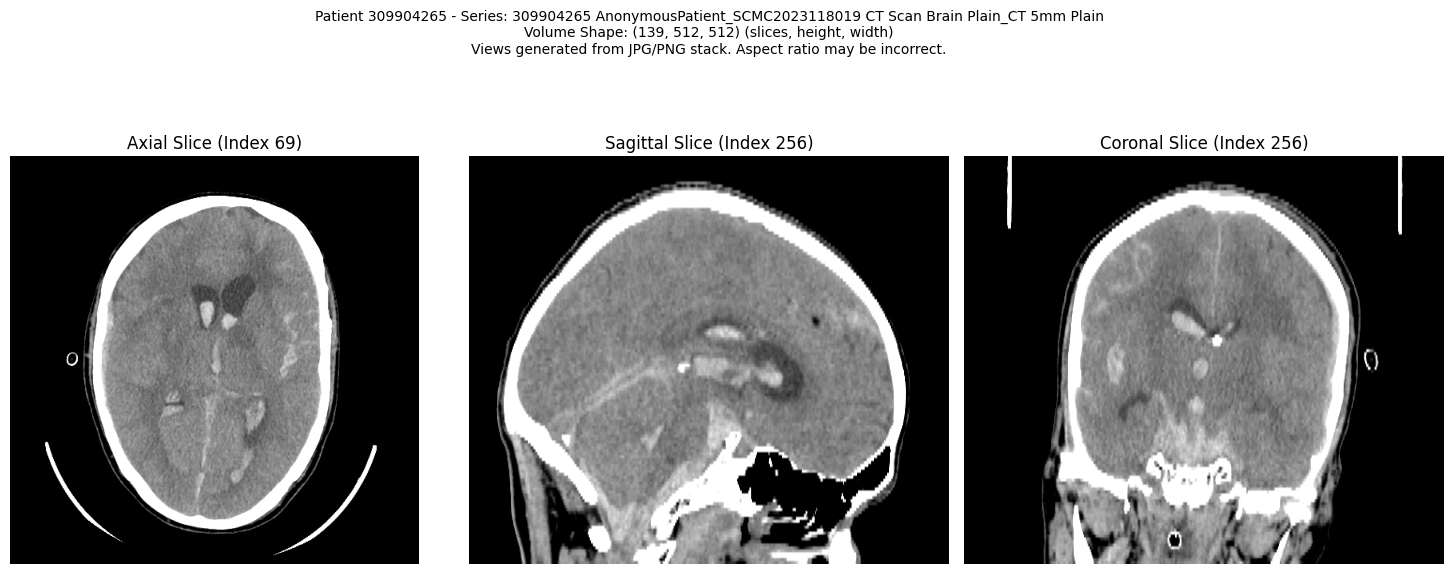

In [6]:
# Import necessary libraries
import os
from pathlib import Path
import numpy as np
# Removed SimpleITK and pydicom
from PIL import Image # For reading JPG/PNG files
from collections import defaultdict
import matplotlib.pyplot as plt # Optional: for displaying results
from tqdm.notebook import tqdm # Optional: for progress bars
import re # For parsing filenames

# --- Configuration ---
YOLO_DATASET_PATH = Path("data/roboflow_dataset/train")
LABEL_DIR = YOLO_DATASET_PATH / "labels"
IMAGE_DIR = YOLO_DATASET_PATH / "images" # Define image dir if needed for checks later

# <<< CHANGED >>> Base path containing patient folders with JPG/PNG images
AXIAL_DATA_BASE_PATH = Path("data/intraparenchymal_intraventricular_subarachnoid_images")
TARGET_SUBFOLDER_SUFFIXES = ["5mm Plain", "Thin Plain"] # Keep this if structure still applies
CLASS_ID_1 = 1
CLASS_ID_2 = 2
# <<< NEW >>> Image file extensions to look for
IMAGE_EXTENSIONS = ['.jpg', '.jpeg', '.png']

# --- Step 1 & 2: Identify Co-occurrence and Extract Patient IDs ---
# (This part remains the same as before)

print("Step 1 & 2: Finding co-occurrence images and extracting patient IDs...")
cooccurrence_files = []
patient_ids = set()

if not LABEL_DIR.is_dir():
    print(f"Error: Label directory not found at {LABEL_DIR}")
else:
    label_files = list(LABEL_DIR.glob("*.txt"))
    print(f"Found {len(label_files)} label files in {LABEL_DIR}.")

    for label_file in tqdm(label_files, desc="Scanning Labels"):
        try:
            with open(label_file, 'r') as f:
                lines = f.readlines()

            found_class1 = False
            found_class2 = False
            for line in lines:
                parts = line.strip().split()
                if not parts: continue
                try:
                    class_id = int(parts[0])
                    if class_id == CLASS_ID_1: found_class1 = True
                    elif class_id == CLASS_ID_2: found_class2 = True
                except (ValueError, IndexError):
                    print(f"Warning: Could not parse line in {label_file}: {line.strip()}")
                    continue
                if found_class1 and found_class2: break

            if found_class1 and found_class2:
                base_filename = label_file.stem
                cooccurrence_files.append(base_filename)
                parts = base_filename.rsplit('_', 1)
                if len(parts) > 0:
                    patient_id = parts[0]
                    patient_ids.add(patient_id)
                else:
                     print(f"Warning: Could not parse patient ID from filename: {base_filename}")
        except Exception as e:
            print(f"Error processing file {label_file}: {e}")

print(f"Found {len(cooccurrence_files)} images with co-occurrence of class {CLASS_ID_1} and {CLASS_ID_2}.")
print(f"Extracted {len(patient_ids)} unique patient IDs: {sorted(list(patient_ids))}")

# --- Step 3: Locate Relevant Axial Image Files (JPG/PNG) ---

print("\nStep 3: Locating relevant axial image files (JPG/PNG)...")
# <<< CHANGED >>> Stores list of image file paths per patient per series folder
patient_image_series = defaultdict(lambda: defaultdict(list))

if not AXIAL_DATA_BASE_PATH.is_dir():
     print(f"Error: Axial data base path not found at {AXIAL_DATA_BASE_PATH}")
else:
    for patient_id in tqdm(sorted(list(patient_ids)), desc="Finding Images"):
        patient_dir = AXIAL_DATA_BASE_PATH / patient_id
        if not patient_dir.is_dir():
            print(f"Warning: Directory not found for patient {patient_id} at {patient_dir}")
            continue

        found_images_for_patient = False
        # Search for relevant subfolders (or directly in patient_dir if no subfolders)
        potential_series_dirs = []
        has_matching_subfolders = False
        for subfolder in patient_dir.iterdir():
             if subfolder.is_dir() and any(subfolder.name.endswith(suffix) for suffix in TARGET_SUBFOLDER_SUFFIXES):
                 potential_series_dirs.append(subfolder)
                 has_matching_subfolders = True

        # If no matching subfolders found, check the patient directory itself
        if not has_matching_subfolders:
             print(f"  Warning: No subfolders matching suffixes found for {patient_id}. Checking patient directory directly.")
             potential_series_dirs.append(patient_dir) # Check the root patient folder

        for series_dir in potential_series_dirs:
            image_files = []
            for ext in IMAGE_EXTENSIONS:
                image_files.extend(list(series_dir.glob(f"*{ext}"))) # Find images

            if image_files:
                print(f"  Found {len(image_files)} image files in {series_dir} for patient {patient_id}.")
                # Store the files under the found series directory
                patient_image_series[patient_id][str(series_dir)].extend(image_files)
                found_images_for_patient = True
            # else:
            #     print(f"    No image files ({'/'.join(IMAGE_EXTENSIONS)}) found in {series_dir}.")

        if not found_images_for_patient:
            print(f"Warning: No relevant image files found for patient {patient_id}")

print(f"Found potential image series for {len(patient_image_series)} patients.")

# --- Step 4: Generate 3D Views from Image Stacks ---

print("\nStep 4: Generating 3D views from image stacks...")
print("!!! WARNING: Generating views from JPG/PNG lacks DICOM metadata (spacing, orientation). !!!")
print("!!! Aspect ratios of sagittal/coronal views might not be anatomically correct. !!!")
print("!!! Slice sorting relies *entirely* on filenames (assuming '{id}_{index}.ext' format). !!!")

patient_views = defaultdict(dict) # To store generated views

# Function to extract sorting key (numeric index) from filename
def get_sort_key_from_filename(filepath):
    """Extracts the integer index from filenames like '..._123.png'"""
    filename = filepath.stem # Get filename without extension
    match = re.search(r'_(\d+)$', filename) # Find digits after the last underscore
    if match:
        return int(match.group(1))
    else:
        # Fallback or error handling if pattern doesn't match
        print(f"Warning: Could not extract numeric index from {filepath.name}. Using 0 as key.")
        return 0 # Or raise an error, or return None and filter later

for patient_id, series_dict in tqdm(patient_image_series.items(), desc="Generating Views"):
    print(f"\nProcessing patient: {patient_id}")
    patient_views[patient_id] = {}
    for series_dir, image_files in series_dict.items():
        print(f"  Processing series directory: {series_dir}")
        if not image_files:
            print("    No image files found for this series. Skipping.")
            continue

        # Sort files based on the extracted numeric index
        try:
            # Create list of (key, path) tuples and sort by key
            sorted_files_with_keys = sorted([(get_sort_key_from_filename(f), f) for f in image_files], key=lambda x: x[0])
            # Keep only the sorted paths
            sorted_files = [item[1] for item in sorted_files_with_keys]
            print(f"    Sorted {len(sorted_files)} files based on filename index.")
            # Optional: print first few sorted names to verify
            # print(f"    Sorted order example: {[f.name for f in sorted_files[:3]]} ...")
        except Exception as e:
            print(f"    Error sorting files for series {series_dir}: {e}. Skipping this series.")
            patient_views[patient_id][series_dir] = {'error': f'File sorting failed: {e}'}
            continue

        # Read images and stack them
        volume_list = []
        for img_path in tqdm(sorted_files, desc="Reading Images", leave=False):
            try:
                # Open image, convert to grayscale ('L') if needed, convert to numpy array
                img = Image.open(img_path).convert('L')
                volume_list.append(np.array(img))
            except Exception as e:
                print(f"    Error reading image {img_path}: {e}")
                # Decide whether to skip the image or the whole series
                # For now, let's skip the series if any image fails
                volume_list = None # Indicate failure
                patient_views[patient_id][series_dir] = {'error': f'Image reading failed: {e} on {img_path.name}'}
                break # Stop processing this series

        if volume_list is None: # Check if reading failed
             continue

        # Stack images into a 3D volume (assuming z, y, x order)
        try:
            if not volume_list:
                 print(f"    No images were successfully read for {series_dir}. Skipping.")
                 continue

            # Check if all images have the same shape before stacking
            first_shape = volume_list[0].shape
            if not all(img.shape == first_shape for img in volume_list):
                 print(f"    Error: Images in {series_dir} have inconsistent shapes. Cannot stack.")
                 patient_views[patient_id][series_dir] = {'error': 'Inconsistent image shapes'}
                 continue

            volume = np.stack(volume_list, axis=0)
            print(f"    Successfully stacked volume with shape: {volume.shape}") # (slices, height, width)

            # Generate representative central slices for views
            z_mid = volume.shape[0] // 2
            y_mid = volume.shape[1] // 2
            x_mid = volume.shape[2] // 2

            axial_slice = volume[z_mid, :, :]
            coronal_slice = volume[:, y_mid, :] # Slice along Y axis
            sagittal_slice = volume[:, :, x_mid] # Slice along X axis

            coronal_slice = np.rot90(coronal_slice, k=2)
            sagittal_slice = np.rot90(sagittal_slice, k=2)

            # Store the views (as NumPy arrays)
            patient_views[patient_id][series_dir] = {
                'axial': axial_slice,
                'sagittal': sagittal_slice,
                'coronal': coronal_slice,
                'volume_shape': volume.shape, # Store shape for context
                'notes': 'Views generated from JPG/PNG stack. Aspect ratio may be incorrect.'
            }
            print(f"    Generated views for series in {series_dir}")

        except Exception as e:
            print(f"    Error processing or stacking images for series {series_dir}: {e}")
            patient_views[patient_id][series_dir] = {'error': f'Stacking/Slicing failed: {e}'}


print("\nProcessing complete.")
print(f"Generated views stored in `patient_views` dictionary for {len(patient_views)} patients.")
print("Reminder: Sagittal/Coronal views likely lack correct aspect ratios due to missing DICOM spacing info.")

# --- Optional: Display an example (remains mostly the same, but check 'error' key) ---
example_patient = None
example_series_dir = None
for pid, series_data in patient_views.items():
    for sdir, data in series_data.items():
        # Check if views were generated successfully (no 'error' key)
        if 'axial' in data and 'error' not in data:
            example_patient = pid
            example_series_dir = sdir
            break
    if example_patient:
        break

if example_patient and example_series_dir:
    print(f"\nDisplaying example views for Patient {example_patient}, Series {example_series_dir}:")
    views = patient_views[example_patient][example_series_dir]

    fig, axes = plt.subplots(1, 3, figsize=(15, 6)) # Increased height slightly for notes

    # Use 'gray' colormap, appropriate for medical images
    # Turn off axes for cleaner look
    axes[0].imshow(views['axial'], cmap='gray')
    axes[0].set_title(f'Axial Slice (Index {views["volume_shape"][0] // 2})')
    axes[0].axis('off')

    # Set aspect='auto' for sagittal/coronal as pixel spacing is unknown/likely non-uniform
    axes[1].imshow(views['sagittal'], cmap='gray', aspect='auto')
    axes[1].set_title(f'Sagittal Slice (Index {views["volume_shape"][2] // 2})')
    axes[1].axis('off')

    axes[2].imshow(views['coronal'], cmap='gray', aspect='auto')
    axes[2].set_title(f'Coronal Slice (Index {views["volume_shape"][1] // 2})')
    axes[2].axis('off')

    fig.suptitle(f"Patient {example_patient} - Series: {Path(example_series_dir).name}\n"
                 f"Volume Shape: {views['volume_shape']} (slices, height, width)\n"
                 f"{views.get('notes', '')}", # Display notes if present
                 fontsize=10)
    plt.tight_layout(rect=[0, 0.03, 1, 0.90]) # Adjust layout further
    plt.show()
else:
    print("\nCould not find a successfully processed series to display.")

In [8]:
import json

# Load patient IDs from cleaned_test.reports_brain_ct.json
with open("data/cleaned_test.reports_brain_ct.json", "r") as f:
    test_reports = json.load(f)

# Extract all patientIds from cleaned test reports
valid_patient_ids = {entry["patient_id"] for entry in test_reports}

# Load the top 80 merged reports
with open("data/top_80_merged_reports.json", "r") as f:
    top_80_reports = json.load(f)

# Filter the reports based on valid patient IDs
filtered_reports = [report for report in top_80_reports if report["patient_id"] in valid_patient_ids]

# Save the filtered reports
with open("data/top_80_filtered_reports.json", "w") as f:
    json.dump(filtered_reports, f, indent=2)

print(f"✅ Done! {len(filtered_reports)} reports saved to 'data/top_80_filtered_reports.json'.")

✅ Done! 685 reports saved to 'data/top_80_filtered_reports.json'.



----- RESULTS FOR TEST DATASET -----


----- ANALYZING TEST DIRECTORY -----
test images directory: data/ct_brain_hemorrhage.v4i.yolov8/test/images
test labels directory: data/ct_brain_hemorrhage.v4i.yolov8/test/labels
Found 248 test images


Analyzing test images:   0%|          | 0/248 [00:00<?, ?it/s]


Processed 248 test images
Found 168 matching files between test and inference
Found 80 images without matching inference results
Found 84 true negative images (no GT and no prediction)
Found 0 class confusion updates
Found 76 misclassified images

----- SUMMARY STATISTICS FOR TEST -----

Total images analyzed: 160
Total misclassifications: 0
Total false positives: 52
Total false negatives: 128
Total true negatives: 84
Total images missing inference: 80

Class statistics for test:
  Class 0 (intraparenchymal):
    Total ground truth: 172
    Total predictions: 144
    Correct predictions: 132
    False negatives: 40
    False positives: 12
  Class 1 (intraventricular):
    Total ground truth: 100
    Total predictions: 84
    Correct predictions: 68
    False negatives: 32
    False positives: 16
  Class 2 (subarachnoid):
    Total ground truth: 128
    Total predictions: 96
    Correct predictions: 72
    False negatives: 56
    False positives: 24
  Class 3 (null):
    True negatives

<Figure size 1000x800 with 0 Axes>

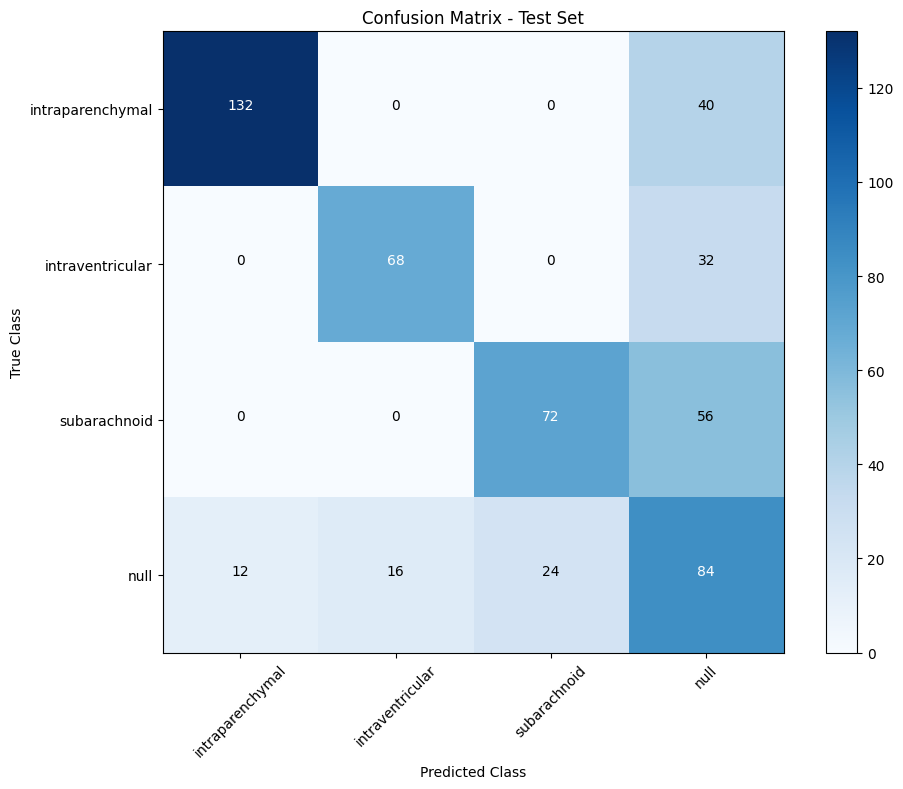


Calculated metrics by class:
  intraparenchymal:
    Precision: 0.9167
    Recall: 0.7674
    F1-Score: 0.8354
  intraventricular:
    Precision: 0.8095
    Recall: 0.6800
    F1-Score: 0.7391
  subarachnoid:
    Precision: 0.7500
    Recall: 0.5625
    F1-Score: 0.6429
  null:
    Precision: 1.0000
    Recall: 1.0000
    F1-Score: 1.0000


<Figure size 1200x600 with 0 Axes>

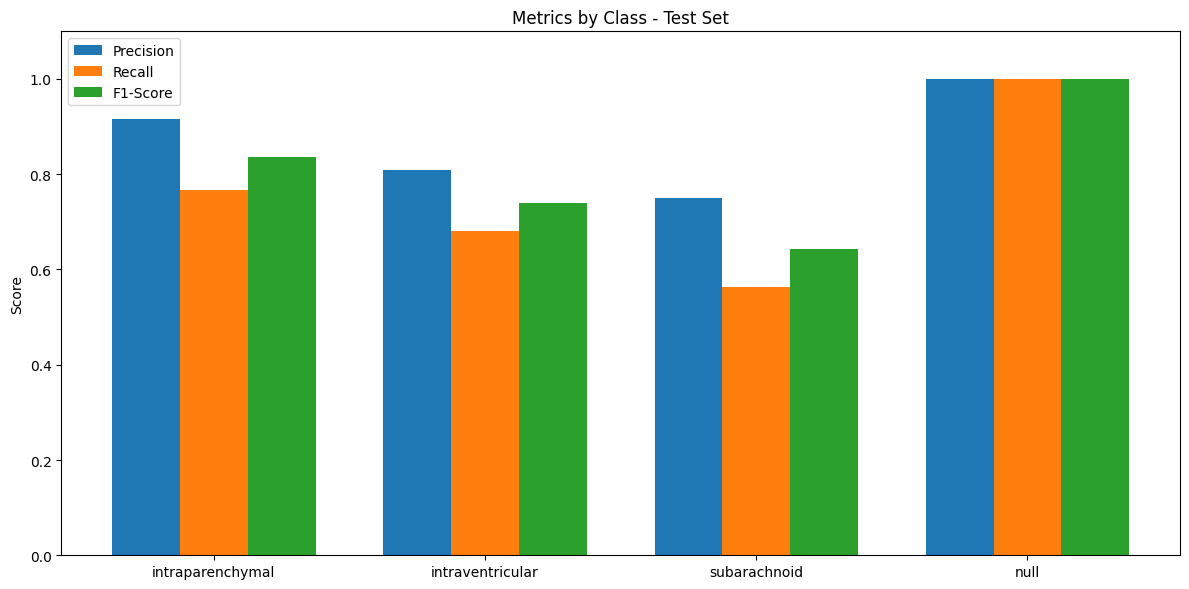

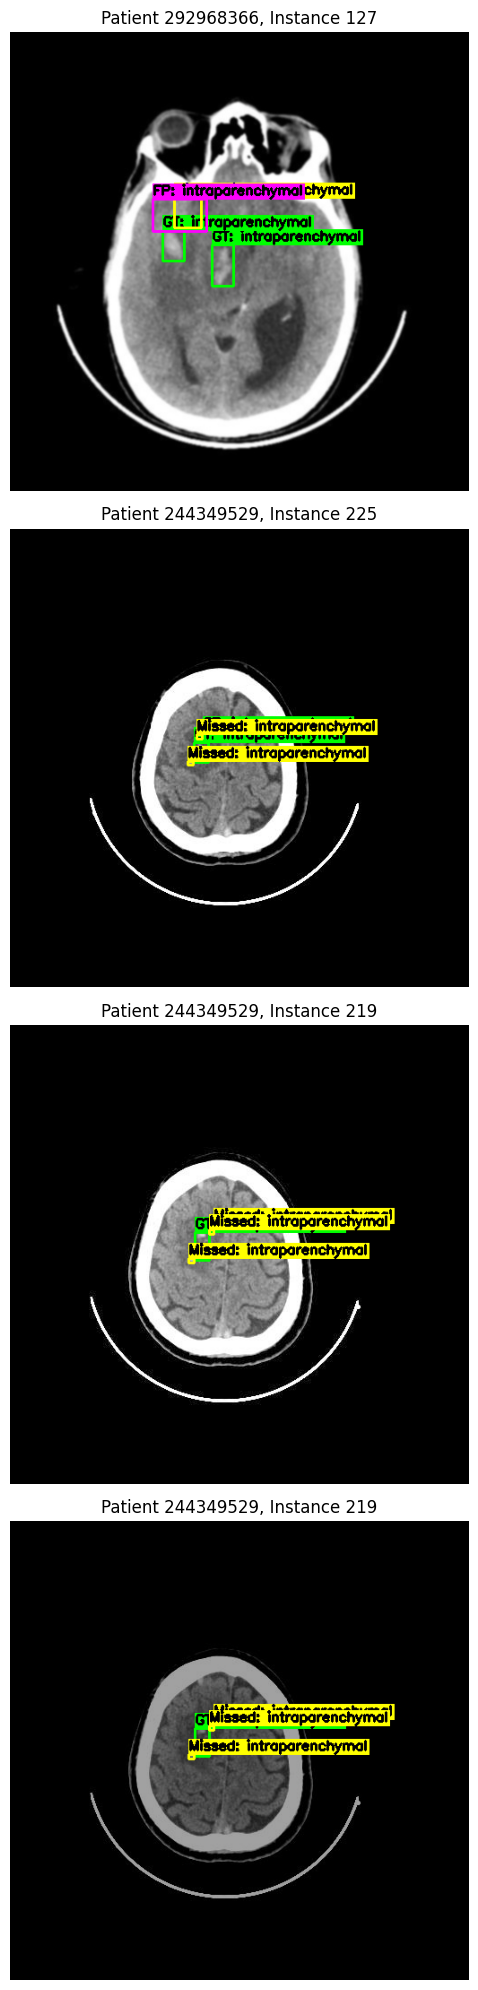


Sample misclassification report for test (20 entries):
   Patient ID Instance                          Misclassification Details
0   292968366      127  Missed intraparenchymal, False positive intrap...
1   244349529      225   Missed intraparenchymal, Missed intraparenchymal
2   244349529      219  Missed intraparenchymal, Missed intraparenchym...
3   244349529      219  Missed intraparenchymal, Missed intraparenchym...
4   292968366      127  Missed intraparenchymal, False positive intrap...
5   270495727      232                            Missed intraventricular
6   294761551      139                            Missed intraventricular
7   261988884       70  Missed intraventricular, False positive intrav...
8   244349529      225   Missed intraparenchymal, Missed intraparenchymal
9   294761551      108           Missed subarachnoid, Missed subarachnoid
10  244349529      225   Missed intraparenchymal, Missed intraparenchymal
11  244349529      233  Missed intraparenchymal, Missed 

Analyzing valid images:   0%|          | 0/760 [00:00<?, ?it/s]


Processed 760 valid images
Found 520 matching files between valid and inference
Found 240 images without matching inference results
Found 260 true negative images (no GT and no prediction)
Found 8 class confusion updates
Found 272 misclassified images

----- SUMMARY STATISTICS FOR VALID -----

Total images analyzed: 532
Total misclassifications: 8
Total false positives: 216
Total false negatives: 540
Total true negatives: 260
Total images missing inference: 240

Class statistics for valid:
  Class 0 (intraparenchymal):
    Total ground truth: 488
    Total predictions: 416
    Correct predictions: 336
    False negatives: 152
    False positives: 72
  Class 1 (intraventricular):
    Total ground truth: 340
    Total predictions: 288
    Correct predictions: 220
    False negatives: 116
    False positives: 68
  Class 2 (subarachnoid):
    Total ground truth: 512
    Total predictions: 312
    Correct predictions: 236
    False negatives: 272
    False positives: 76
  Class 3 (null):
 

<Figure size 1000x800 with 0 Axes>

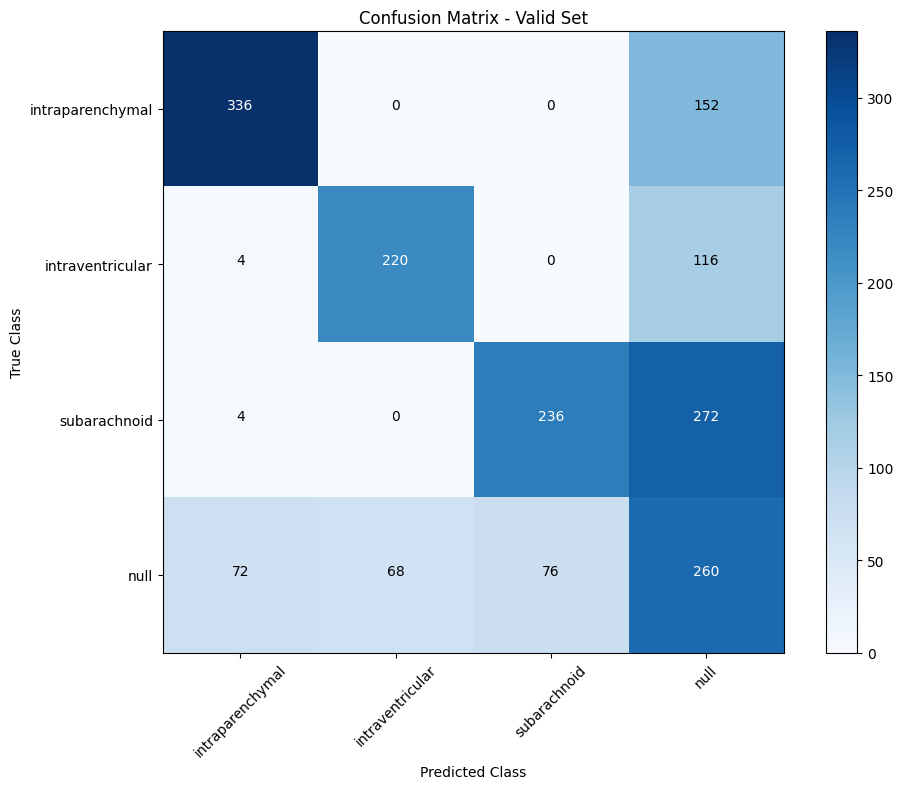


Calculated metrics by class:
  intraparenchymal:
    Precision: 0.8235
    Recall: 0.6885
    F1-Score: 0.7500
  intraventricular:
    Precision: 0.7639
    Recall: 0.6548
    F1-Score: 0.7051
  subarachnoid:
    Precision: 0.7564
    Recall: 0.4646
    F1-Score: 0.5756
  null:
    Precision: 1.0000
    Recall: 1.0000
    F1-Score: 1.0000


<Figure size 1200x600 with 0 Axes>

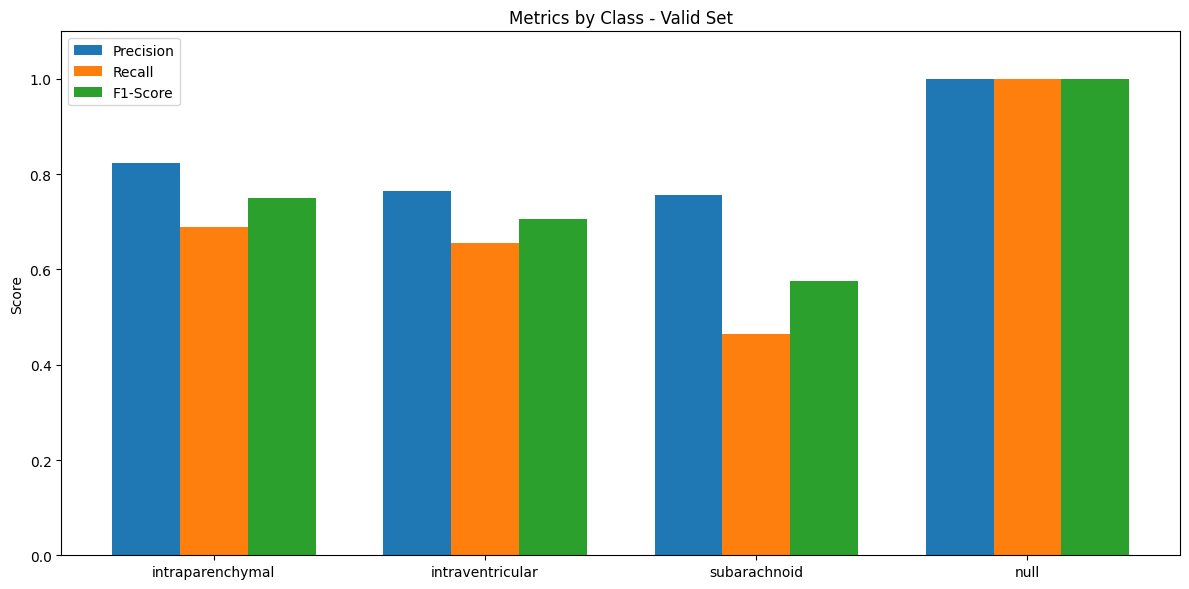

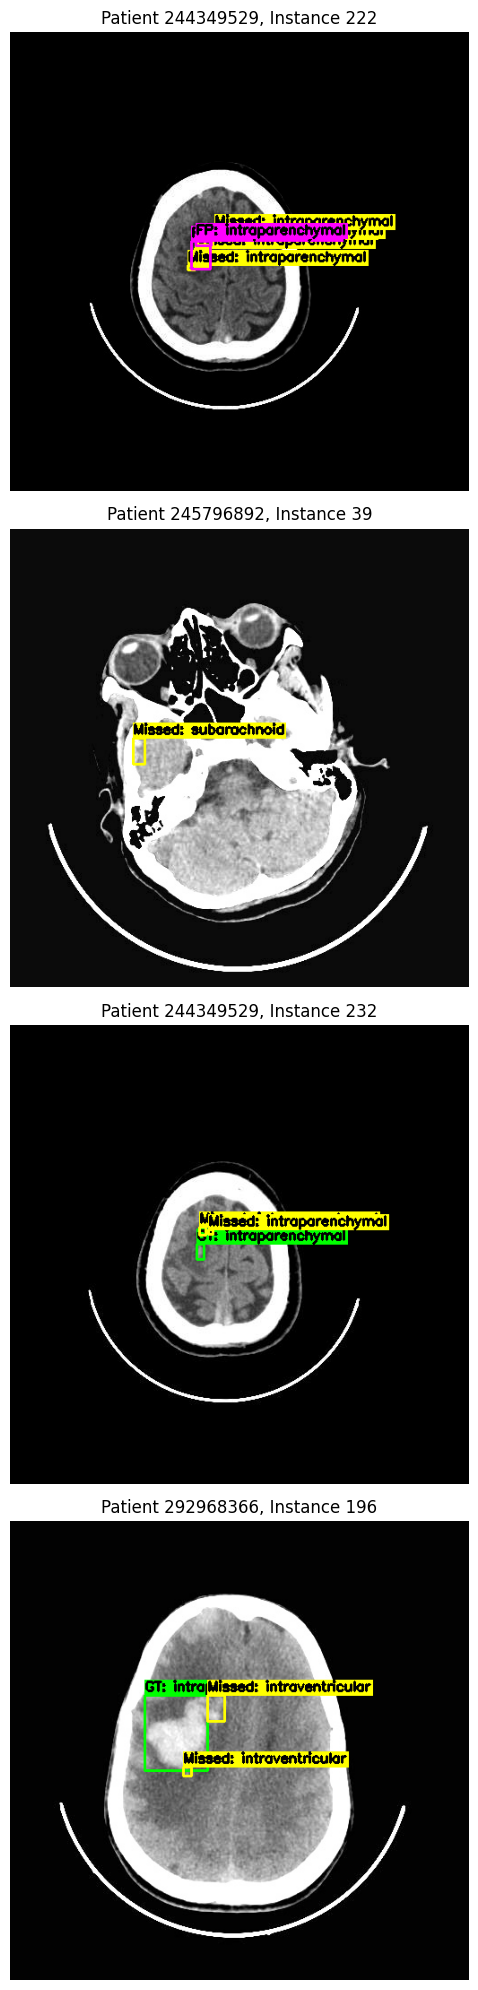


Sample misclassification report for valid (20 entries):
   Patient ID Instance                          Misclassification Details
0   244349529      222  Missed intraparenchymal, Missed intraparenchym...
1   245796892       39                                Missed subarachnoid
2   244349529      232   Missed intraparenchymal, Missed intraparenchymal
3   292968366      196   Missed intraventricular, Missed intraventricular
4   261988884       73   Missed intraventricular, Missed intraventricular
5   270495727      204  Missed intraparenchymal, False positive intrap...
6   292968366      196   Missed intraventricular, Missed intraventricular
7   270588824      134                                Missed subarachnoid
8   294761551      155                    False positive intraventricular
9   270066339       67  Missed subarachnoid, False positive intraventr...
10  255239800       91  Missed subarachnoid, Missed subarachnoid, Fals...
11  270495727      129  Missed intraparenchymal, False 

<Figure size 1400x800 with 0 Axes>

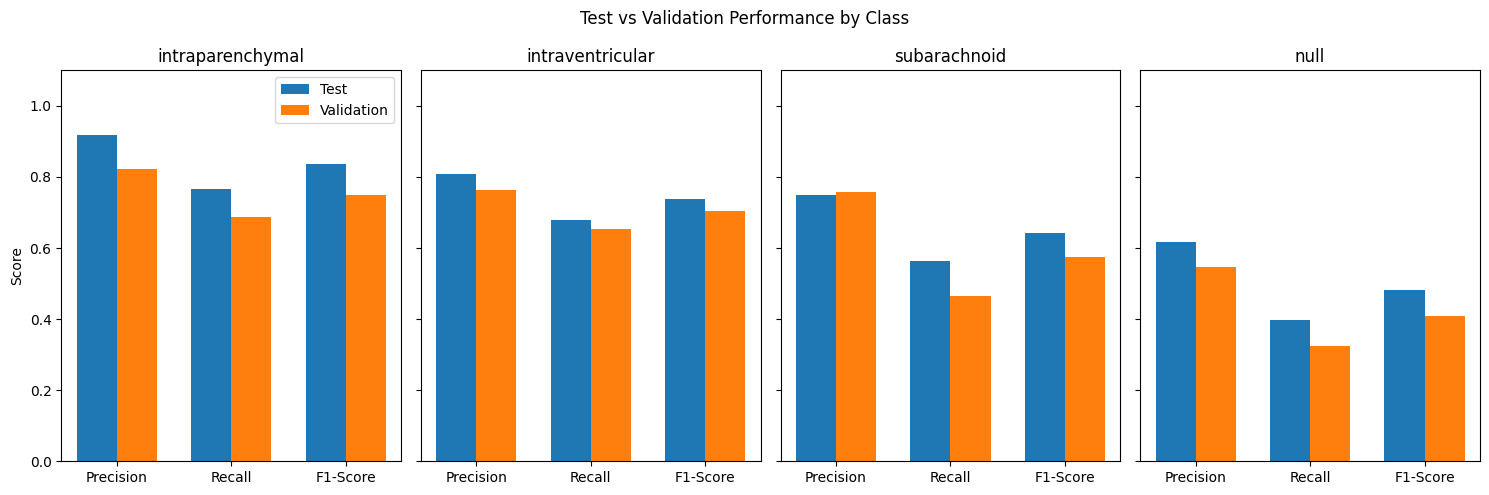

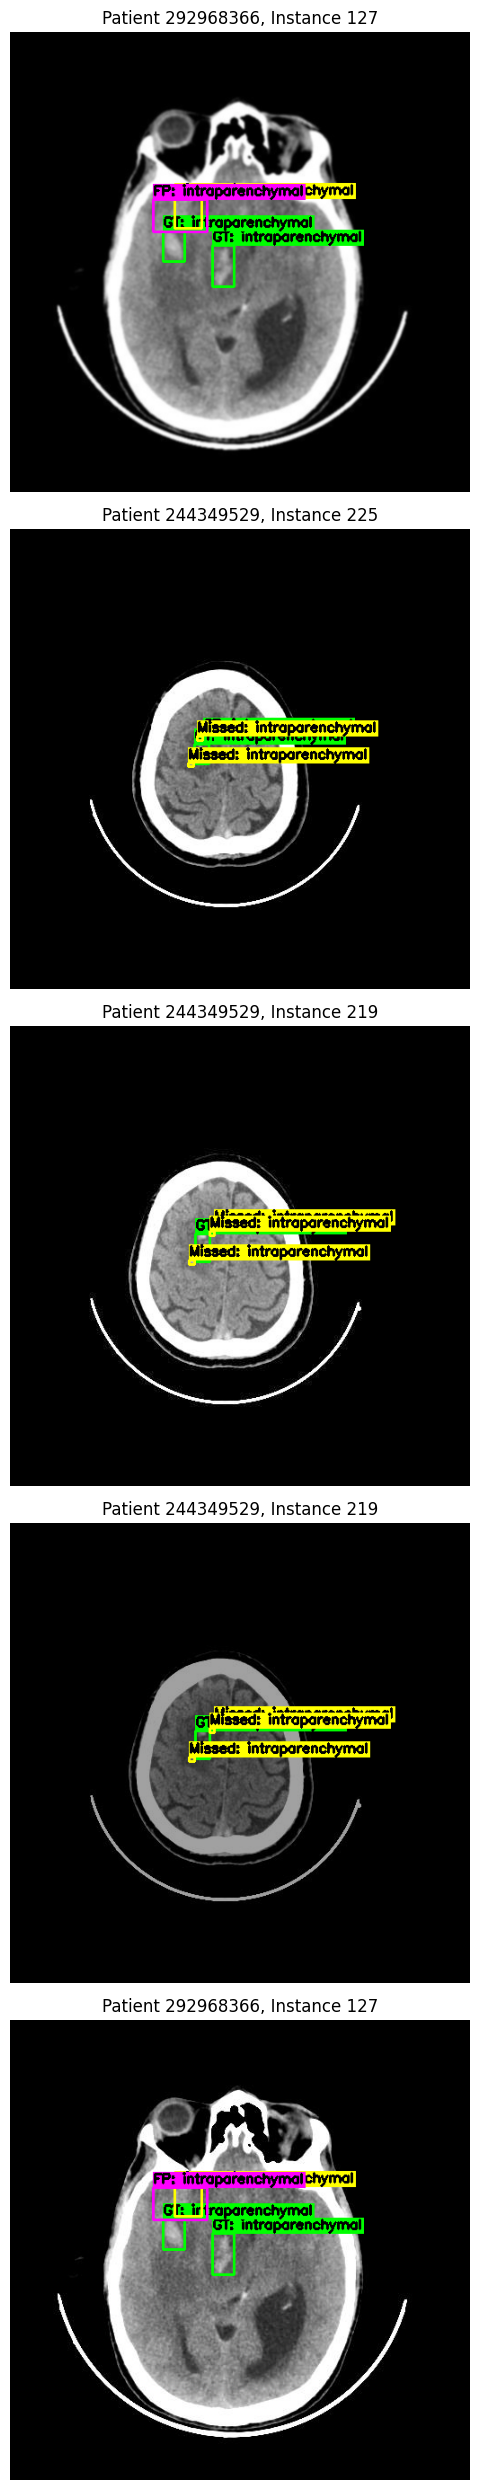


Sample misclassification report (combined sets):
   Patient ID Instance                          Misclassification Details
0   292968366      127  Missed intraparenchymal, False positive intrap...
1   244349529      225   Missed intraparenchymal, Missed intraparenchymal
2   244349529      219  Missed intraparenchymal, Missed intraparenchym...
3   244349529      219  Missed intraparenchymal, Missed intraparenchym...
4   292968366      127  Missed intraparenchymal, False positive intrap...
5   270495727      232                            Missed intraventricular
6   294761551      139                            Missed intraventricular
7   261988884       70  Missed intraventricular, False positive intrav...
8   244349529      225   Missed intraparenchymal, Missed intraparenchymal
9   294761551      108           Missed subarachnoid, Missed subarachnoid
10  244349529      225   Missed intraparenchymal, Missed intraparenchymal
11  244349529      233  Missed intraparenchymal, Missed intrap

In [31]:
# CT Brain Hemorrhage Misclassification Visualization - Fixed
# This notebook visualizes misclassifications between ground truth labels and model predictions
# with proper null class handling

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from tqdm.notebook import tqdm
import pandas as pd
from collections import defaultdict

# Define paths
original_dataset_path = "data/ct_brain_hemorrhage.v6i.yolov8"
inference_results_path = "data/intraparenchymal_intraventricular_subarachnoid_images"

# Class names (adjust as needed for your specific dataset)
class_names = ["intraparenchymal", "intraventricular", "subarachnoid", "null"]

# Analysis settings
include_missing_inference = True  # Include images without inference results
analyze_valid_dir = True  # Analyze validation directory as well

# Define analysis function for a specific dataset split
def analyze_dataset_split(split_name):
    """
    Analyze misclassifications for a specific dataset split (test or valid)
    """
    # Get all images for the specified split
    images_dir = os.path.join(original_dataset_path, split_name, "images")
    label_dir = os.path.join(original_dataset_path, split_name, "labels")
    
    # Check if directories exist and print them for debugging
    print(f"\n----- ANALYZING {split_name.upper()} DIRECTORY -----")
    print(f"{split_name} images directory: {images_dir}")
    print(f"{split_name} labels directory: {label_dir}")
    
    # Add safety check for directory existence
    if not os.path.exists(images_dir):
        print(f"Warning: {split_name} images directory not found: {images_dir}")
        return {}, []
    
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    print(f"Found {len(image_files)} {split_name} images")
    
    # Initialize counters
    misclassification_counts = {
        'class_confusion': defaultdict(int),  # (true_class, pred_class) -> count
        'false_positives': defaultdict(int),  # class_id -> count
        'false_negatives': defaultdict(int),  # class_id -> count
        'total_gt_by_class': defaultdict(int),  # class_id -> count
        'total_pred_by_class': defaultdict(int),  # class_id -> count
        'correct_by_class': defaultdict(int),  # class_id -> count
        'missing_inference': 0,  # Count of images without inference results
        'true_negatives': 0,  # NEW: Count of true negatives (no GT and no pred)
        'true_empty_images': 0,  # NEW: Count of images with no annotations in either GT or pred
    }
    
    # List to store misclassification examples for visualization
    misclassifications = []
    
    # Keep track of processed files for debugging
    processed_count = 0
    matching_files_count = 0
    confusion_updates = 0
    missing_inference_count = 0
    true_negative_count = 0  # NEW: Counter for true negatives
    
    # Process each image
    for image_file in tqdm(image_files, desc=f"Analyzing {split_name} images"):
        processed_count += 1
        image_path = os.path.join(images_dir, image_file)
        label_path = os.path.join(label_dir, os.path.splitext(image_file)[0] + '.txt')
        
        # Extract patient ID and instance number
        patient_id, instance_no = extract_patient_and_instance(image_file)
        if not patient_id or not instance_no:
            continue
        
        # Find corresponding inference files
        inference_image_path, inference_label_path = find_corresponding_inference_files(patient_id, instance_no)
        
        # Read ground truth annotations
        gt_annotations = []
        if os.path.exists(label_path):
            gt_annotations = read_yolo_label(label_path, normalize=True)
        
        # Update total counts by class for ground truth
        for ann in gt_annotations:
            class_id = int(ann[0])
            if class_id < len(class_names):
                misclassification_counts['total_gt_by_class'][class_id] += 1
        
        # Handle missing inference results
        if not inference_image_path or not inference_label_path:
            missing_inference_count += 1
            misclassification_counts['missing_inference'] += 1
            
            if include_missing_inference:
                # If no ground truth annotations - this is a TRUE NEGATIVE
                if not gt_annotations:
                    misclassification_counts['true_negatives'] += 1
                    misclassification_counts['correct_by_class'][3] += 1  # Correctly predicted as null class
                    true_negative_count += 1
                else:
                    # If we have ground truth but no prediction - these are FALSE NEGATIVES
                    has_misclassification = True
                    
                    # Count as false negatives since the model didn't produce any predictions
                    for ann in gt_annotations:
                        class_id = int(ann[0])
                        if class_id < len(class_names):
                            # Count as false negative since there's no prediction
                            misclassification_counts['false_negatives'][class_id] += 1
                    
                    # Add to misclassification examples
                    misclassifications.append({
                        'image_path': image_path,
                        'gt_annotations': gt_annotations,
                        'pred_annotations': [],  # Empty predictions
                        'matched_pairs': [],  # No matches
                        'unmatched_gt': list(range(len(gt_annotations))),  # All ground truth unmatched
                        'unmatched_pred': [],  # No predictions
                        'patient_id': patient_id,
                        'instance_no': instance_no,
                        'missing_inference': True
                    })
            
            continue
        
        matching_files_count += 1
        
        # Get image dimensions (for normalization)
        img_width = 512  # Default, will be overridden if we can read the image
        img_height = 512  # Default, will be overridden if we can read the image
        
        try:
            img = cv2.imread(image_path)
            if img is not None:
                img_height, img_width = img.shape[:2]
        except Exception as e:
            pass  # Use default dimensions if image can't be read
        
        # Predictions may be in absolute pixel format - normalize them
        pred_annotations = []
        if os.path.exists(inference_label_path):
            pred_annotations = read_yolo_label(inference_label_path, normalize=True, 
                                           img_width=img_width, img_height=img_height)
        
        # Update total counts by class for predictions
        for ann in pred_annotations:
            class_id = int(ann[0])
            if class_id < len(class_names):
                misclassification_counts['total_pred_by_class'][class_id] += 1
        
        # IMPORTANT: Handle the case where both ground truth and predictions are empty
        # This is a true negative - correctly predicted as "null"
        if not gt_annotations and not pred_annotations:
            misclassification_counts['true_negatives'] += 1
            misclassification_counts['correct_by_class'][3] += 1  # Null class index
            misclassification_counts['true_empty_images'] += 1
            true_negative_count += 1
            continue  # Skip to next image
        
        # Match boxes based on IoU
        matched_pairs, unmatched_gt, unmatched_pred = match_boxes(gt_annotations, pred_annotations)
        
        # Check for class mismatches in matched boxes
        has_misclassification = False
        for gt_idx, pred_idx, iou in matched_pairs:
            gt_class = int(gt_annotations[gt_idx][0])
            pred_class = int(pred_annotations[pred_idx][0])
            
            # Skip if class IDs are invalid
            if gt_class >= len(class_names) or pred_class >= len(class_names):
                continue
            
            if gt_class == pred_class:
                misclassification_counts['correct_by_class'][gt_class] += 1
            else:
                misclassification_counts['class_confusion'][(gt_class, pred_class)] += 1
                confusion_updates += 1
                has_misclassification = True
        
        # Count false negatives (unmatched ground truth)
        for gt_idx in unmatched_gt:
            gt_class = int(gt_annotations[gt_idx][0])
            if gt_class < len(class_names):
                misclassification_counts['false_negatives'][gt_class] += 1
                has_misclassification = True
        
        # Count false positives (unmatched predictions)
        for pred_idx in unmatched_pred:
            pred_class = int(pred_annotations[pred_idx][0])
            if pred_class < len(class_names):
                misclassification_counts['false_positives'][pred_class] += 1
                has_misclassification = True
        
        # If this image has any misclassification, add it to our examples
        if has_misclassification:
            misclassifications.append({
                'image_path': image_path,
                'gt_annotations': gt_annotations,
                'pred_annotations': pred_annotations,
                'matched_pairs': matched_pairs,
                'unmatched_gt': unmatched_gt,
                'unmatched_pred': unmatched_pred,
                'patient_id': patient_id,
                'instance_no': instance_no,
                'missing_inference': False
            })
    
    # Print diagnostic information
    print(f"\nProcessed {processed_count} {split_name} images")
    print(f"Found {matching_files_count} matching files between {split_name} and inference")
    print(f"Found {missing_inference_count} images without matching inference results")
    print(f"Found {true_negative_count} true negative images (no GT and no prediction)")
    print(f"Found {confusion_updates} class confusion updates")
    print(f"Found {len(misclassifications)} misclassified images")
    
    return misclassification_counts, misclassifications

# Functions to parse YOLO label files
def read_yolo_label(label_path, normalize=True, img_width=512, img_height=512):
    """
    Reads a YOLO format label file and returns a list of annotations
    Each annotation is (class_id, x_center, y_center, width, height)
    If normalize is True, converts pixel coordinates to normalized coordinates (0-1)
    If normalize is False, keeps the coordinates as-is
    """
    if not os.path.exists(label_path):
        return []
    
    annotations = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:  # YOLO format: class_id, x_center, y_center, width, height
                values = [float(x) for x in parts]
                
                # Check if values are likely in pixel coordinates (> 1.0) and need normalization
                if not normalize:
                    annotations.append(values)
                elif values[1] > 1.0 or values[2] > 1.0 or values[3] > 1.0 or values[4] > 1.0:
                    # Convert pixel coordinates to normalized (0-1)
                    class_id = values[0]
                    x_center = values[1] / img_width
                    y_center = values[2] / img_height
                    width = values[3] / img_width
                    height = values[4] / img_height
                    annotations.append([class_id, x_center, y_center, width, height])
                else:
                    # Already normalized
                    annotations.append(values)
    return annotations

def extract_patient_and_instance(filename):
    """
    Extract patient ID and instance number from filename
    Example: "244349529_219_png.rf.91bb8ef90126de12d0e06e59dfede18a_brightness_contrast.jpg"
    Returns: ("244349529", "219")
    """
    # Extract the base part before any transformations
    base_part = os.path.basename(filename).split('.')[0]
    match = re.match(r'(\d+)_(\d+)', base_part)
    
    if match:
        patient_id, instance_no = match.groups()
        return patient_id, instance_no
    return None, None

def find_corresponding_inference_files(patient_id, instance_no):
    """
    Find the corresponding image and label files in the inference results directory
    """
    # First find the patient directory
    patient_dir = os.path.join(inference_results_path, patient_id)
    if not os.path.exists(patient_dir):
        return None, None
    
    # Find all subdirectories in the patient directory
    subdirs = [d for d in os.listdir(patient_dir) if os.path.isdir(os.path.join(patient_dir, d))]
    
    # Look for image and label files in the subdirectories
    image_file = None
    label_file = None
    
    for subdir in subdirs:
        # Check if this is an images directory (not containing '_labels')
        if '_labels' not in subdir:
            potential_image = os.path.join(patient_dir, subdir, f"{patient_id}_{instance_no}.png")
            if os.path.exists(potential_image):
                image_file = potential_image
        
        # Check if this is a labels directory
        if '_labels' in subdir:
            potential_label = os.path.join(patient_dir, subdir, f"{patient_id}_{instance_no}.txt")
            if os.path.exists(potential_label):
                label_file = potential_label
    
    return image_file, label_file

def compute_iou(box1, box2):
    """
    Compute IoU between two boxes in YOLO format
    box format: [x_center, y_center, width, height]
    """
    # Convert YOLO format to corners
    box1_x1 = box1[0] - box1[2]/2
    box1_y1 = box1[1] - box1[3]/2
    box1_x2 = box1[0] + box1[2]/2
    box1_y2 = box1[1] + box1[3]/2
    
    box2_x1 = box2[0] - box2[2]/2
    box2_y1 = box2[1] - box2[3]/2
    box2_x2 = box2[0] + box2[2]/2
    box2_y2 = box2[1] + box2[3]/2
    
    # Find intersection area
    x1 = max(box1_x1, box2_x1)
    y1 = max(box1_y1, box2_y1)
    x2 = min(box1_x2, box2_x2)
    y2 = min(box1_y2, box2_y2)
    
    if x2 < x1 or y2 < y1:
        return 0.0
    
    intersection_area = (x2 - x1) * (y2 - y1)
    
    # Find union area
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    
    union_area = box1_area + box2_area - intersection_area
    
    return intersection_area / union_area

def match_boxes(ground_truth_boxes, prediction_boxes, iou_threshold=0.5):
    """
    Match ground truth boxes with predicted boxes using IoU
    Returns:
        matched_pairs: list of (gt_idx, pred_idx, iou)
        unmatched_gt: list of gt_idx
        unmatched_pred: list of pred_idx
    """
    if not ground_truth_boxes or not prediction_boxes:
        # If either is empty, return all unmatched
        return [], list(range(len(ground_truth_boxes))), list(range(len(prediction_boxes)))
    
    # Extract just the boxes (without class id)
    gt_boxes = [box[1:5] for box in ground_truth_boxes]
    pred_boxes = [box[1:5] for box in prediction_boxes]
    
    # Calculate IoU for all possible pairs
    iou_matrix = np.zeros((len(gt_boxes), len(pred_boxes)))
    for i, gt_box in enumerate(gt_boxes):
        for j, pred_box in enumerate(pred_boxes):
            iou_matrix[i, j] = compute_iou(gt_box, pred_box)
    
    # Find matches using greedy approach
    matched_pairs = []
    unmatched_gt = list(range(len(gt_boxes)))
    unmatched_pred = list(range(len(pred_boxes)))
    
    # Sort all IoUs in descending order
    iou_flat = iou_matrix.flatten()
    iou_indices = np.argsort(iou_flat)[::-1]
    
    # Greedily match boxes with highest IoU first
    for idx in iou_indices:
        if iou_flat[idx] < iou_threshold:
            break
            
        gt_idx = idx // len(pred_boxes)
        pred_idx = idx % len(pred_boxes)
        
        if gt_idx in unmatched_gt and pred_idx in unmatched_pred:
            matched_pairs.append((gt_idx, pred_idx, iou_flat[idx]))
            unmatched_gt.remove(gt_idx)
            unmatched_pred.remove(pred_idx)
    
    return matched_pairs, unmatched_gt, unmatched_pred

def draw_box(image, box, color, label=None, is_yolo_format=True):
    """
    Draw bounding box on image
    box format: [x_center, y_center, width, height] if is_yolo_format is True
                [x1, y1, x2, y2] if is_yolo_format is False
    """
    height, width = image.shape[:2]
    
    if is_yolo_format:
        # Convert from YOLO format to pixel coordinates
        x_center, y_center, w, h = box
        x1 = int((x_center - w/2) * width)
        y1 = int((y_center - h/2) * height)
        x2 = int((x_center + w/2) * width)
        y2 = int((y_center + h/2) * height)
    else:
        x1, y1, x2, y2 = [int(coord) for coord in box]
    
    # Ensure coordinates are within image bounds
    x1 = max(0, min(x1, width - 1))
    y1 = max(0, min(y1, height - 1))
    x2 = max(0, min(x2, width - 1))
    y2 = max(0, min(y2, height - 1))
    
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
    
    if label:
        # Draw label background and text
        text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
        cv2.rectangle(image, (x1, y1 - text_size[1] - 5), (x1 + text_size[0], y1), color, -1)
        cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

def visualize_misclassification_example(example, class_names, max_examples=5):
    """
    Visualize a misclassification example
    """
    image = cv2.imread(example['image_path'])
    if image is None:
        print(f"Could not read image: {example['image_path']}")
        return None
    
    # Convert BGR to RGB for matplotlib
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]
    
    # Create a copy of the image for drawing
    vis_image = image.copy()
    
    # Draw matched boxes
    for gt_idx, pred_idx, iou in example['matched_pairs']:
        gt_box = example['gt_annotations'][gt_idx]
        pred_box = example['pred_annotations'][pred_idx]
        
        gt_class = int(gt_box[0])
        pred_class = int(pred_box[0])
        
        # Draw ground truth box in green if correct, red if misclassified
        if gt_class == pred_class:
            gt_color = (0, 255, 0)  # Green for correct
            gt_label = f"GT: {class_names[gt_class]}"
        else:
            gt_color = (255, 0, 0)  # Red for incorrect
            gt_label = f"GT: {class_names[gt_class]}"
        
        # Ensure annotations are in normalized format (0-1)
        gt_box_norm = gt_box[1:5]
        # Convert normalized coordinates to pixel coordinates for drawing
        draw_box(vis_image, gt_box_norm, gt_color, gt_label, is_yolo_format=True)
        
        # If misclassified, draw the prediction box in blue
        if gt_class != pred_class:
            pred_color = (0, 0, 255)  # Blue for prediction
            pred_label = f"Pred: {class_names[pred_class]}"
            
            # Ensure annotations are in normalized format (0-1)
            pred_box_norm = pred_box[1:5]
            draw_box(vis_image, pred_box_norm, pred_color, pred_label, is_yolo_format=True)
    
    # Draw unmatched ground truth boxes (false negatives) in yellow
    for gt_idx in example['unmatched_gt']:
        gt_box = example['gt_annotations'][gt_idx]
        gt_class = int(gt_box[0])
        gt_label = f"Missed: {class_names[gt_class]}"
        
        # Ensure annotations are in normalized format (0-1)
        gt_box_norm = gt_box[1:5]
        draw_box(vis_image, gt_box_norm, (255, 255, 0), gt_label, is_yolo_format=True)  # Yellow
    
    # Draw unmatched prediction boxes (false positives) in purple
    for pred_idx in example['unmatched_pred']:
        pred_box = example['pred_annotations'][pred_idx]
        pred_class = int(pred_box[0])
        pred_label = f"FP: {class_names[pred_class]}"
        
        # Ensure annotations are in normalized format (0-1)
        pred_box_norm = pred_box[1:5]
        draw_box(vis_image, pred_box_norm, (255, 0, 255), pred_label, is_yolo_format=True)  # Purple
    
    return vis_image

def visualize_confusion_matrix(misclassification_counts, class_names):
    """
    Visualize confusion matrix for misclassifications
    """
    # Create confusion matrix
    n_classes = len(class_names)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=int)
    
    # Fill in confusion matrix
    for (true_class, pred_class), count in misclassification_counts['class_confusion'].items():
        # Skip invalid indices
        if true_class < n_classes and pred_class < n_classes:
            confusion_matrix[true_class, pred_class] = count
    
    # Add diagonal (correct predictions)
    for class_id, count in misclassification_counts['correct_by_class'].items():
        # Skip invalid indices
        if class_id < n_classes:
            confusion_matrix[class_id, class_id] = count
    
    # Add false negatives to the "null" class column (last column)
    null_class_idx = n_classes - 1  # Index of the null class
    for class_id, count in misclassification_counts['false_negatives'].items():
        if class_id < n_classes - 1:  # Only for actual hemorrhage classes, not for null class itself
            # False negatives are cases where the true class is class_id but no prediction was made
            # We represent this as predicting "null" for that class
            confusion_matrix[class_id, null_class_idx] += count
    
    # Add false positives to the "null" class row (last row)
    for class_id, count in misclassification_counts['false_positives'].items():
        if class_id < n_classes - 1:  # Only for actual hemorrhage classes, not for null class itself
            # False positives are cases where the true class is nothing (null) but predicted as class_id
            confusion_matrix[null_class_idx, class_id] += count
    
    # Print the confusion matrix for debugging
    print("\nConfusion Matrix:")
    for i in range(n_classes):
        row_str = "  "
        for j in range(n_classes):
            row_str += f"{confusion_matrix[i, j]:4d} "
        print(f"{class_names[i]:15s}: {row_str}")
    
    # Check if the confusion matrix has any non-zero values
    if np.sum(confusion_matrix) == 0:
        print("WARNING: Confusion matrix is empty (all zeros). No misclassifications found.")
        # Add dummy values for visualization
        np.fill_diagonal(confusion_matrix, 1)
        print("Added dummy values to diagonal for visualization purposes.")
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    # Add labels
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Add text annotations
    thresh = max(1, confusion_matrix.max() / 2.)  # Avoid division by zero
    for i in range(n_classes):
        for j in range(n_classes):
            plt.text(j, i, format(confusion_matrix[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if confusion_matrix[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    
    return plt.gcf()

def visualize_metrics_by_class(misclassification_counts, class_names):
    """
    Visualize precision, recall, and F1-score for each class
    """
    # Calculate metrics
    metrics = {'Precision': [], 'Recall': [], 'F1-Score': []}
    
    # Check if we have any data to visualize
    has_data = False
    for class_id in range(len(class_names)):
        tp = misclassification_counts['correct_by_class'].get(class_id, 0)
        fp = misclassification_counts['false_positives'].get(class_id, 0)
        fn = misclassification_counts['false_negatives'].get(class_id, 0)
        
        if tp > 0 or fp > 0 or fn > 0:
            has_data = True
            break
    
    if not has_data:
        print("WARNING: No classification data found to calculate metrics.")
        # Create a figure with a message
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.text(0.5, 0.5, "No classification data available for metrics calculation", 
                horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title('Metrics by Class (No Data)')
        ax.axis('off')
        return fig
    
    # Calculate metrics for each class (including null class now)
    for class_id in range(len(class_names)):
        # For null class, true positives are the true negatives count
        tp = misclassification_counts['correct_by_class'].get(class_id, 0)
        if class_id == len(class_names) - 1:  # Null class
            # Override with true negatives count
            tp = misclassification_counts['true_negatives']
        
        # Precision = TP / (TP + FP)
        fp = misclassification_counts['false_positives'].get(class_id, 0)
        
        if tp + fp > 0:
            precision = tp / (tp + fp)
        else:
            precision = 0
        
        # Recall = TP / (TP + FN)
        fn = misclassification_counts['false_negatives'].get(class_id, 0)
        
        if tp + fn > 0:
            recall = tp / (tp + fn)
        else:
            recall = 0
        
        # F1-Score = 2 * (Precision * Recall) / (Precision + Recall)
        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0
        
        metrics['Precision'].append(precision)
        metrics['Recall'].append(recall)
        metrics['F1-Score'].append(f1)
    
    # Print the calculated metrics for debugging
    print("\nCalculated metrics by class:")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name}:")
        print(f"    Precision: {metrics['Precision'][i]:.4f}")
        print(f"    Recall: {metrics['Recall'][i]:.4f}")
        print(f"    F1-Score: {metrics['F1-Score'][i]:.4f}")
    
    # Create bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(class_names))
    width = 0.25
    
    ax.bar(x - width, metrics['Precision'], width, label='Precision')
    ax.bar(x, metrics['Recall'], width, label='Recall')
    ax.bar(x + width, metrics['F1-Score'], width, label='F1-Score')
    
    ax.set_ylabel('Score')
    ax.set_title('Metrics by Class')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names)
    ax.legend()
    
    # Set y-axis limits
    ax.set_ylim([0, 1.1])
    
    plt.tight_layout()
    return plt.gcf()

def analyze_and_visualize_split(split_name):
    """
    Analyze and visualize results for a specific dataset split (test or valid)
    """
    print(f"\n----- RESULTS FOR {split_name.upper()} DATASET -----\n")
    
    # Analyze this split
    misclassification_counts, misclassifications = analyze_dataset_split(split_name)
    
    # Display summary statistics
    print(f"\n----- SUMMARY STATISTICS FOR {split_name.upper()} -----\n")
    print(f"Total images analyzed: {len(misclassifications) + misclassification_counts['true_negatives']}")
    print(f"Total misclassifications: {sum(misclassification_counts['class_confusion'].values())}")
    print(f"Total false positives: {sum(misclassification_counts['false_positives'].values())}")
    print(f"Total false negatives: {sum(misclassification_counts['false_negatives'].values())}")
    print(f"Total true negatives: {misclassification_counts['true_negatives']}")
    print(f"Total images missing inference: {misclassification_counts['missing_inference']}")
    
    # Print class statistics
    print(f"\nClass statistics for {split_name}:")
    for class_id in range(len(class_names)):
        class_name = class_names[class_id]
        if class_id == len(class_names) - 1:  # Null class
            # For null class, special handling
            print(f"  Class {class_id} ({class_name}):")
            print(f"    True negatives (correctly identified as null): {misclassification_counts['true_negatives']}")
            print(f"    False positives (predicted as non-null when null): {sum(misclassification_counts['false_positives'].values())}")
        else:
            # Normal classes
            print(f"  Class {class_id} ({class_name}):")
            print(f"    Total ground truth: {misclassification_counts['total_gt_by_class'].get(class_id, 0)}")
            print(f"    Total predictions: {misclassification_counts['total_pred_by_class'].get(class_id, 0)}")
            print(f"    Correct predictions: {misclassification_counts['correct_by_class'].get(class_id, 0)}")
            print(f"    False negatives: {misclassification_counts['false_negatives'].get(class_id, 0)}")
            print(f"    False positives: {misclassification_counts['false_positives'].get(class_id, 0)}")
    
    # Print confusion matrix raw values
    print(f"\nConfusion matrix raw values for {split_name}:")
    print(f"  Diagonal (correct predictions):")
    for class_id, count in misclassification_counts['correct_by_class'].items():
        class_name = class_names[class_id]
        if class_id == len(class_names) - 1:  # Null class
            print(f"    True class {class_name} -> Predicted class {class_name}: {misclassification_counts['true_negatives']}")
        else:
            print(f"    True class {class_name} -> Predicted class {class_name}: {count}")
    
    print(f"  Off-diagonal (misclassifications):")
    for (true_class, pred_class), count in misclassification_counts['class_confusion'].items():
        if true_class < len(class_names) and pred_class < len(class_names):
            true_name = class_names[true_class]
            pred_name = class_names[pred_class]
            print(f"    True class {true_name} -> Predicted class {pred_name}: {count}")
    
    print(f"  False negatives (missed detections):")
    for class_id, count in misclassification_counts['false_negatives'].items():
        if class_id < len(class_names) - 1:  # Skip null class
            class_name = class_names[class_id]
            print(f"    True class {class_name} -> Predicted as null: {count}")
    
    print(f"  False positives (spurious detections):")
    for class_id, count in misclassification_counts['false_positives'].items():
        if class_id < len(class_names) - 1:  # Skip null class
            class_name = class_names[class_id]
            print(f"    True class null -> Predicted as {class_name}: {count}")
    
    # Visualize confusion matrix
    plt.figure(figsize=(10, 8))
    confusion_matrix_fig = visualize_confusion_matrix(misclassification_counts, class_names)
    plt.title(f"Confusion Matrix - {split_name.capitalize()} Set")
    plt.tight_layout()
    plt.show()
    
    # Visualize metrics by class
    plt.figure(figsize=(12, 6))
    metrics_fig = visualize_metrics_by_class(misclassification_counts, class_names)
    plt.title(f"Metrics by Class - {split_name.capitalize()} Set")
    plt.tight_layout()
    plt.show()
    
    # Visualize sample misclassifications
    if misclassifications and len(misclassifications) > 0:  # Make sure misclassifications is not None and not empty
        num_examples = min(4, len(misclassifications))
        if num_examples > 0:
            plt.figure(figsize=(15, 5 * num_examples))
            
            for i in range(num_examples):
                example = misclassifications[i]
                
                if example.get('missing_inference', False):
                    # For examples with missing inference, just show ground truth
                    image = cv2.imread(example['image_path'])
                    if image is not None:
                        # Convert BGR to RGB for matplotlib
                        vis_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        
                        # Draw ground truth boxes
                        for idx, gt_box in enumerate(example['gt_annotations']):
                            gt_class = int(gt_box[0])
                            if gt_class < len(class_names):
                                gt_label = f"GT: {class_names[gt_class]} (No inference)"
                                draw_box(vis_image, gt_box[1:5], (255, 0, 0), gt_label, is_yolo_format=True)  # Red
                        
                        plt.subplot(num_examples, 1, i+1)
                        plt.imshow(vis_image)
                        plt.title(f"Patient {example['patient_id']}, Instance {example['instance_no']} - NO INFERENCE AVAILABLE")
                        plt.axis('off')
                else:
                    # For normal examples, show both ground truth and predictions
                    vis_image = visualize_misclassification_example(example, class_names)
                    
                    if vis_image is not None:
                        plt.subplot(num_examples, 1, i+1)
                        plt.imshow(vis_image)
                        plt.title(f"Patient {example['patient_id']}, Instance {example['instance_no']}")
                        plt.axis('off')
            
            plt.tight_layout()
            plt.show()
    else:
        print(f"No misclassification examples found for {split_name} dataset.")
    
    # Create a detailed report of misclassified samples
    if misclassifications and len(misclassifications) > 0:
        report_data = []
        
        for example in misclassifications:
            patient_id = example['patient_id']
            instance_no = example['instance_no']
            
            if example.get('missing_inference', False):
                misclass_details = ["No inference available"]
                
                # Add details about missed ground truth
                for gt_idx, gt_ann in enumerate(example['gt_annotations']):
                    gt_class = int(gt_ann[0])
                    if gt_class < len(class_names):
                        misclass_details.append(f"Missed {class_names[gt_class]}")
            else:
                misclass_details = []
                
                # Check for class mismatches in matched boxes
                for gt_idx, pred_idx, iou in example['matched_pairs']:
                    gt_class = int(example['gt_annotations'][gt_idx][0])
                    pred_class = int(example['pred_annotations'][pred_idx][0])
                    
                    if gt_class != pred_class and gt_class < len(class_names) and pred_class < len(class_names):
                        misclass_details.append(f"Class mismatch: GT={class_names[gt_class]}, Pred={class_names[pred_class]}")
                
                # Check for false negatives
                for gt_idx in example['unmatched_gt']:
                    gt_class = int(example['gt_annotations'][gt_idx][0])
                    if gt_class < len(class_names):
                        misclass_details.append(f"Missed {class_names[gt_class]}")
                
                # Check for false positives
                for pred_idx in example['unmatched_pred']:
                    pred_class = int(example['pred_annotations'][pred_idx][0])
                    if pred_class < len(class_names):
                        misclass_details.append(f"False positive {class_names[pred_class]}")
            
            report_data.append({
                'Patient ID': patient_id,
                'Instance': instance_no,
                'Misclassification Details': ', '.join(misclass_details)
            })
        
        # Create DataFrame and display
        misclass_df = pd.DataFrame(report_data)
        print(f"\nSample misclassification report for {split_name} ({min(20, len(misclass_df))} entries):")
        print(misclass_df.head(20))  # Use print instead of display
        
        # Save to CSV
        csv_filename = f'data/{split_name}_misclassification_report.csv'
        misclass_df.to_csv(csv_filename, index=False)
        print(f"Full report saved to '{csv_filename}'")
    else:
        print(f"No misclassification examples to report for {split_name} dataset.")
    
    return misclassification_counts, misclassifications

# Main execution
# Analyze test set
test_counts, test_misclassifications = analyze_and_visualize_split('test')
test_results = (test_counts, test_misclassifications)

# Analyze validation set if enabled
if analyze_valid_dir:
    valid_counts, valid_misclassifications = analyze_and_visualize_split('valid')
    valid_results = (valid_counts, valid_misclassifications)

# Compare test and validation results if both were analyzed
if analyze_valid_dir:
    test_counts, test_misclassifications = test_results
    valid_counts, valid_misclassifications = valid_results
    
    print("\n----- COMPARISON BETWEEN TEST AND VALIDATION SETS -----\n")
    
    # Compare basic statistics
    print("Basic Statistics Comparison:")
    print(f"  Test set false negatives: {sum(test_counts['false_negatives'].values())}")
    print(f"  Validation set false negatives: {sum(valid_counts['false_negatives'].values())}")
    print(f"  Test set false positives: {sum(test_counts['false_positives'].values())}")
    print(f"  Validation set false positives: {sum(valid_counts['false_positives'].values())}")
    print(f"  Test set true negatives: {test_counts['true_negatives']}")
    print(f"  Validation set true negatives: {valid_counts['true_negatives']}")
    print(f"  Test set missing inference: {test_counts['missing_inference']}")
    print(f"  Validation set missing inference: {valid_counts['missing_inference']}")
    
    # Compare accuracy by class
    print("\nAccuracy by class:")
    for class_id in range(len(class_names)):
        class_name = class_names[class_id]
        
        if class_id == len(class_names) - 1:  # Null class
            # For null class, use true negatives
            test_tp = test_counts['true_negatives']
            test_fp = sum(test_counts['false_positives'].values())
            test_fn = sum(test_counts['false_negatives'].values())
            
            valid_tp = valid_counts['true_negatives']
            valid_fp = sum(valid_counts['false_positives'].values())
            valid_fn = sum(valid_counts['false_negatives'].values())
        else:
            # For normal classes
            test_tp = test_counts['correct_by_class'].get(class_id, 0)
            test_fp = test_counts['false_positives'].get(class_id, 0)
            test_fn = test_counts['false_negatives'].get(class_id, 0)
            
            valid_tp = valid_counts['correct_by_class'].get(class_id, 0)
            valid_fp = valid_counts['false_positives'].get(class_id, 0)
            valid_fn = valid_counts['false_negatives'].get(class_id, 0)
        
        # Calculate accuracy metrics
        test_precision = test_tp / max(1, test_tp + test_fp)
        test_recall = test_tp / max(1, test_tp + test_fn)
        test_f1 = 2 * test_precision * test_recall / max(0.001, test_precision + test_recall)
        
        valid_precision = valid_tp / max(1, valid_tp + valid_fp)
        valid_recall = valid_tp / max(1, valid_tp + valid_fn)
        valid_f1 = 2 * valid_precision * valid_recall / max(0.001, valid_precision + valid_recall)
        
        print(f"  Class {class_id} ({class_name}):")
        print(f"    Test - Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
        print(f"    Valid - Precision: {valid_precision:.4f}, Recall: {valid_recall:.4f}, F1: {valid_f1:.4f}")
    
    # Create a combined bar chart for comparison
    plt.figure(figsize=(14, 8))
    
    # Prepare data for comparison chart
    metrics = ['Precision', 'Recall', 'F1-Score']
    test_metrics = []
    valid_metrics = []
    
    for class_id in range(len(class_names)):
        # Test set metrics
        if class_id == len(class_names) - 1:  # Null class
            # Use true negatives for null class
            tp_test = test_counts['true_negatives']
            fp_test = sum(test_counts['false_positives'].values())
            fn_test = sum(test_counts['false_negatives'].values())
        else:
            tp_test = test_counts['correct_by_class'].get(class_id, 0)
            fp_test = test_counts['false_positives'].get(class_id, 0)
            fn_test = test_counts['false_negatives'].get(class_id, 0)
        
        precision_test = tp_test / (tp_test + fp_test) if (tp_test + fp_test) > 0 else 0
        recall_test = tp_test / (tp_test + fn_test) if (tp_test + fn_test) > 0 else 0
        f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test) if (precision_test + recall_test) > 0 else 0
        
        test_metrics.append([precision_test, recall_test, f1_test])
        
        # Validation set metrics
        if class_id == len(class_names) - 1:  # Null class
            # Use true negatives for null class
            tp_valid = valid_counts['true_negatives']
            fp_valid = sum(valid_counts['false_positives'].values())
            fn_valid = sum(valid_counts['false_negatives'].values())
        else:
            tp_valid = valid_counts['correct_by_class'].get(class_id, 0)
            fp_valid = valid_counts['false_positives'].get(class_id, 0)
            fn_valid = valid_counts['false_negatives'].get(class_id, 0)
        
        precision_valid = tp_valid / (tp_valid + fp_valid) if (tp_valid + fp_valid) > 0 else 0
        recall_valid = tp_valid / (tp_valid + fn_valid) if (tp_valid + fn_valid) > 0 else 0
        f1_valid = 2 * (precision_valid * recall_valid) / (precision_valid + recall_valid) if (precision_valid + recall_valid) > 0 else 0
        
        valid_metrics.append([precision_valid, recall_valid, f1_valid])
    
    # Create subplot for each class
    fig, axs = plt.subplots(1, len(class_names), figsize=(15, 5), sharey=True)
    x = np.arange(len(metrics))
    width = 0.35
    
    for i, (class_name, ax) in enumerate(zip(class_names, axs)):
        ax.bar(x - width/2, test_metrics[i], width, label='Test')
        ax.bar(x + width/2, valid_metrics[i], width, label='Validation')
        ax.set_title(class_name)
        ax.set_xticks(x)
        ax.set_xticklabels(metrics)
        ax.set_ylim([0, 1.1])
        
        if i == 0:
            ax.set_ylabel('Score')
            ax.legend()
    
    plt.suptitle('Test vs Validation Performance by Class')
    plt.tight_layout()
    plt.show()

    # Combine misclassifications from both sets for visualization
    misclassifications = test_misclassifications + valid_misclassifications

    # Visualize sample misclassifications
    num_examples = min(5, len(misclassifications))
    if num_examples > 0:
        plt.figure(figsize=(15, 5 * num_examples))
        
        for i in range(num_examples):
            example = misclassifications[i]
            vis_image = visualize_misclassification_example(example, class_names)
            
            if vis_image is not None:
                plt.subplot(num_examples, 1, i+1)
                plt.imshow(vis_image)
                plt.title(f"Patient {example['patient_id']}, Instance {example['instance_no']}")
                plt.axis('off')
        
        plt.tight_layout()
        plt.show()

    # Create a detailed report of misclassified samples
    if misclassifications:
        report_data = []
        
        for example in misclassifications:
            patient_id = example['patient_id']
            instance_no = example['instance_no']
            
            misclass_details = []
            
            # Check for class mismatches in matched boxes
            for gt_idx, pred_idx, iou in example['matched_pairs']:
                gt_class = int(example['gt_annotations'][gt_idx][0])
                pred_class = int(example['pred_annotations'][pred_idx][0])
                
                if gt_class != pred_class and gt_class < len(class_names) and pred_class < len(class_names):
                    misclass_details.append(f"Class mismatch: GT={class_names[gt_class]}, Pred={class_names[pred_class]}")
            
            # Check for false negatives
            for gt_idx in example['unmatched_gt']:
                gt_class = int(example['gt_annotations'][gt_idx][0])
                if gt_class < len(class_names):
                    misclass_details.append(f"Missed {class_names[gt_class]}")
            
            # Check for false positives
            for pred_idx in example['unmatched_pred']:
                pred_class = int(example['pred_annotations'][pred_idx][0])
                if pred_class < len(class_names):
                    misclass_details.append(f"False positive {class_names[pred_class]}")
            
            report_data.append({
                'Patient ID': patient_id,
                'Instance': instance_no,
                'Misclassification Details': ', '.join(misclass_details)
            })
        
        # Create DataFrame and display
        misclass_df = pd.DataFrame(report_data)
        print("\nSample misclassification report (combined sets):")
        print(misclass_df.head(20))
        
        # Save to CSV
        misclass_df.to_csv('data/misclassification_report.csv', index=False)
        print("Full report saved to 'data/misclassification_report.csv'")

Top pathologies by frequency:

pns: 287
intracranial_hemorrhage: 255
trauma_or_skull_injury: 200
ischemic_injury_or_infarct: 176
diffuse_cerebral_atrophy: 110
neoplasm_or_mass: 96
calcification_or_granuloma: 67
cerebral_edema: 46
rare_brain: 45
hydrocephalus: 41
inaccurate_study: 40
artifact: 25
cystic_lesion: 19
vascular_lesion: 15


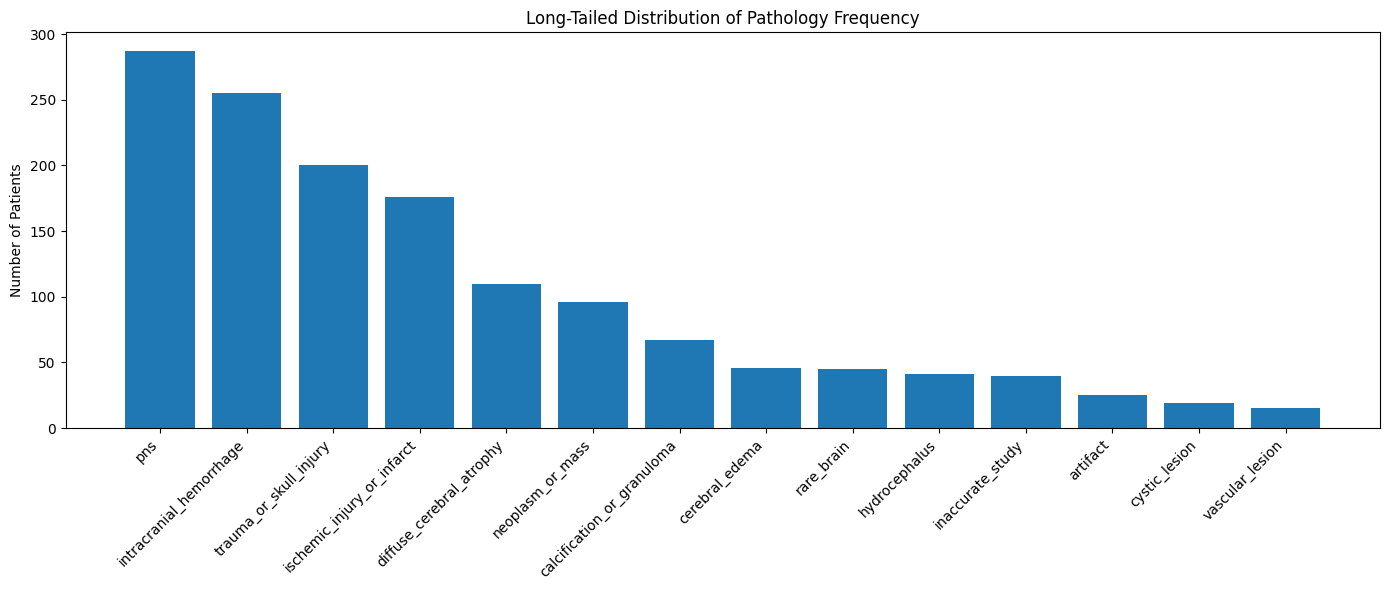

In [1]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt

# Load your patient-level JSON file
with open('data/pathology_processed_reports.json', 'r') as f:
    patients = json.load(f)

# Initialize frequency dictionary
pathology_freq = defaultdict(int)

# Count how many patients have each pathology present
for patient in patients:
    for key, value in patient.items():
        if isinstance(value, dict) and 'is_present' in value:
            if value['is_present']:
                pathology_freq[key] += 1

# Sort by frequency descending to get long-tailed structure
sorted_freq = sorted(pathology_freq.items(), key=lambda x: x[1], reverse=True)

# Print top pathologies
print("Top pathologies by frequency:\n")
for pathology, count in sorted_freq:
    print(f"{pathology}: {count}")

# Plot long-tailed distribution
pathologies = [p for p, _ in sorted_freq]
counts = [c for _, c in sorted_freq]

plt.figure(figsize=(14, 6))
plt.bar(pathologies, counts)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Patients")
plt.title("Long-Tailed Distribution of Pathology Frequency")
plt.tight_layout()
plt.show()

In [2]:
import os

# Base path to your dataset directory
base_path = "/Users/yugambahl/Desktop/brain_ct/data/training_datasets/archived/current_20251105/UAT_CT_BRAIN_HEMORRHAGE.v2i.yolov8_combined"

# Define the folders to inspect
folders = ['backup', 'train', 'valid', 'test']
subfolders = ['images', 'labels']

# Iterate through each folder and subfolder
for folder in folders:
    print(f"\n--- {folder.upper()} ---")
    for sub in subfolders:
        sub_path = os.path.join(base_path, folder, sub)
        if os.path.exists(sub_path):
            count = len([
                f for f in os.listdir(sub_path)
                if os.path.isfile(os.path.join(sub_path, f))
            ])
            print(f"{sub}: {count} files")
        else:
            print(f"{sub}: Not found")


--- BACKUP ---
images: Not found
labels: Not found

--- TRAIN ---
images: 5989 files
labels: 5989 files

--- VALID ---
images: 1220 files
labels: 1220 files

--- TEST ---
images: 335 files
labels: 335 files


In [4]:
import os
from collections import defaultdict

def check_label_consistency(folder_path):
    images_dir = os.path.join(folder_path, "images")
    labels_dir = os.path.join(folder_path, "labels")

    # Get all image files
    image_files = [f for f in os.listdir(images_dir) if f.endswith(".jpg")]

    # Group image files by patient_instance_id (before .rf.*)
    patient_image_map = defaultdict(list)
    for f in image_files:
        prefix = f.split(".rf")[0]  # Extract patient_instance_id
        patient_image_map[prefix].append(f)

    for patient_instance_id, images in patient_image_map.items():
        label_files = [os.path.splitext(img)[0] + ".txt" for img in images]
        
        label_contents = []
        for label_file in label_files:
            label_path = os.path.join(labels_dir, label_file)
            if not os.path.exists(label_path):
                print(f"[{folder_path}] Missing label file: {label_file}")
                continue
            with open(label_path, "r") as f:
                content = f.read().strip()
                label_contents.append((label_file, content))

        if not label_contents:
            print(f"[{folder_path}] No label files found for {patient_instance_id}")
            continue

        reference_content = label_contents[0][1]
        inconsistent_files = [name for name, content in label_contents if content != reference_content]

        if inconsistent_files:
            print(f"[{folder_path}] Inconsistent labels for {patient_instance_id}:")
            for f in inconsistent_files:
                print(f" - {f}")

# Run check for all sets
for folder in ['train', 'val', 'test']:
    check_label_consistency(f"data/ct_brain_hemorrhage.v6i.yolov8/{folder}")

[data/ct_brain_hemorrhage.v6i.yolov8/train] Inconsistent labels for 245796892_76_png:
 - 245796892_76_png.rf.06eca2524e696150d2d6efc179866485.txt
 - 245796892_76_png.rf.06eca2524e696150d2d6efc179866485_random_gamma.txt
[data/ct_brain_hemorrhage.v6i.yolov8/train] Inconsistent labels for 294761551_89_png:
 - 294761551_89_png.rf.494c33cca362981fdb0bea3489d56be1.txt
[data/ct_brain_hemorrhage.v6i.yolov8/train] Inconsistent labels for 270495727_218_png:
 - 270495727_218_png.rf.86fe047227242a105276555a73c1f571.txt
 - 270495727_218_png.rf.b5e28eccd5e8a65a350fd2c39bd62578_random_gamma.txt
 - 270495727_218_png.rf.b5e28eccd5e8a65a350fd2c39bd62578.txt
[data/ct_brain_hemorrhage.v6i.yolov8/train] Inconsistent labels for 292968366_191_png:
 - 292968366_191_png.rf.280c9e0482cd914c3640292823f2cd9e.txt
 - 292968366_191_png.rf.b2a8e8594e6220c1028bdedd9b47c5af.txt
 - 292968366_191_png.rf.280c9e0482cd914c3640292823f2cd9e_random_gamma.txt
[data/ct_brain_hemorrhage.v6i.yolov8/train] Inconsistent labels for 2

In [10]:
import os

def get_patient_status(images_folder, labels_folder):
    patient_status = {}

    # Collect all image filenames
    for filename in os.listdir(images_folder):
        if filename.endswith(".jpg"):
            patient_id = filename.split("_")[0]
            if patient_id not in patient_status:
                patient_status[patient_id] = 'normal'  # default

            # Find all label files for this patient
            label_files = [
                f for f in os.listdir(labels_folder)
                if f.startswith(patient_id) and f.endswith(".txt")
            ]

            # Check if any label file is non-empty (indicating hemorrhage)
            for label_file in label_files:
                label_path = os.path.join(labels_folder, label_file)
                if os.path.getsize(label_path) > 0:
                    patient_status[patient_id] = 'abnormal'
                    break  # early exit if any label is non-empty

    return patient_status

# === Usage ===
images_folder = "/Users/yugambahl/Desktop/brain_ct/data/ct_brain_hemorrhage.v6i.yolov8/test/images"
labels_folder = "/Users/yugambahl/Desktop/brain_ct/data/ct_brain_hemorrhage.v6i.yolov8/test/labels"

status_map = get_patient_status(images_folder, labels_folder)

# Print patient statuses
print("Patient ID | Status")
for pid in sorted(status_map):
    print(f"{pid} | {status_map[pid]}")

# Count totals
normal_count = sum(1 for status in status_map.values() if status == 'normal')
abnormal_count = sum(1 for status in status_map.values() if status == 'abnormal')

print("\nSummary:")
print(f"Total normal patients: {normal_count}")
print(f"Total abnormal patients: {abnormal_count}")

Patient ID | Status
255886226 | abnormal
270588824 | abnormal
282005096 | abnormal
284343192 | abnormal
288374967 | normal
292664627 | normal
300170719 | abnormal
302320546 | normal
311476012 | normal
319044553 | abnormal

Summary:
Total normal patients: 4
Total abnormal patients: 6


In [4]:
import os
import glob
from PIL import Image

def yolo_to_medsam_bbox(yolo_line, image_width, image_height):
    """
    Convert single YOLOv8 annotation line to MedSAM bbox format
    
    Args:
        yolo_line: "class_id x_center y_center width height" (string)
        image_width: actual image width in pixels
        image_height: actual image height in pixels
    
    Returns:
        dict with class_id and bbox in [x_min, y_min, x_max, y_max] format
    """
    parts = yolo_line.strip().split()
    class_id = int(parts[0])
    x_center = float(parts[1])
    y_center = float(parts[2])
    width = float(parts[3])
    height = float(parts[4])
    
    # Convert normalized coordinates to absolute pixel coordinates
    x_center_abs = x_center * image_width
    y_center_abs = y_center * image_height
    width_abs = width * image_width
    height_abs = height * image_height
    
    # Convert center-based to corner-based coordinates
    x_min = int(x_center_abs - width_abs/2)
    y_min = int(y_center_abs - height_abs/2)
    x_max = int(x_center_abs + width_abs/2)
    y_max = int(y_center_abs + height_abs/2)
    
    return {
        'class_id': class_id,
        'bbox': [x_min, y_min, x_max, y_max]
    }

def process_single_image_annotation(image_path, label_path):
    """
    Process a single image and its corresponding label file
    
    Returns:
        List of bounding boxes in MedSAM format
    """
    # Get image dimensions
    with Image.open(image_path) as img:
        img_width, img_height = img.size
    
    # Read YOLO annotations
    bboxes = []
    with open(label_path, 'r') as f:
        for line in f:
            if line.strip():  # Skip empty lines
                bbox_data = yolo_to_medsam_bbox(line, img_width, img_height)
                bboxes.append(bbox_data)
    
    return bboxes, (img_width, img_height)

def convert_yolo_dataset_to_medsam(images_dir, labels_dir, output_file=None):
    """
    Convert entire YOLOv8 dataset to MedSAM format
    
    Args:
        images_dir: Path to images folder (e.g., "test/images")
        labels_dir: Path to labels folder (e.g., "test/labels") 
        output_file: Optional file to save conversion results
    """
    results = []
    
    # Get all label files
    label_files = glob.glob(os.path.join(labels_dir, "*.txt"))
    
    for label_path in label_files:
        # Get corresponding image file
        label_filename = os.path.basename(label_path)
        image_filename = label_filename.replace('.txt', '.png')
        image_path = os.path.join(images_dir, image_filename)
        
        if not os.path.exists(image_path):
            print(f"Warning: Image not found for {label_filename}")
            continue
        
        # Convert annotations
        bboxes, (img_w, img_h) = process_single_image_annotation(image_path, label_path)
        
        result = {
            'image_path': image_path,
            'image_filename': image_filename,
            'image_size': (img_w, img_h),
            'bboxes': bboxes
        }
        results.append(result)
        
        # Print conversion for this image
        print(f"\nImage: {image_filename} ({img_w}x{img_h})")
        for i, bbox_data in enumerate(bboxes):
            print(f"  Object {i+1} (class {bbox_data['class_id']}): {bbox_data['bbox']}")
    
    # Save results if output file specified
    if output_file:
        import json
        with open(output_file, 'w') as f:
            json.dump(results, f, indent=2)
        print(f"\nResults saved to {output_file}")
    
    return results

def convert_image_to_medsam_format(image_path):
    """
    Convert a single image's YOLOv8 labels to MedSAM format
    
    Args:
        image_path: Path to the image file (e.g., "test/images/image_001.png")
    
    Returns:
        Dictionary with image info and converted bounding boxes
    """
    # Derive label path from image path
    # Assuming structure: test/images/image.png -> test/labels/image.txt
    image_dir = os.path.dirname(image_path)
    image_filename = os.path.basename(image_path)
    image_name = os.path.splitext(image_filename)[0]
    
    # Get the parent directory and construct label path
    parent_dir = os.path.dirname(image_dir)
    label_path = os.path.join(parent_dir, "labels", f"{image_name}.txt")
    
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    if not os.path.exists(label_path):
        raise FileNotFoundError(f"Label file not found: {label_path}")
    
    # Get image dimensions
    with Image.open(image_path) as img:
        img_width, img_height = img.size
    
    print(f"Image: {image_filename}")
    print(f"Dimensions: {img_width} x {img_height}")
    print(f"Label file: {os.path.basename(label_path)}")
    print("-" * 50)
    
    # Read and convert YOLO annotations
    medsam_bboxes = []
    with open(label_path, 'r') as f:
        for line_num, line in enumerate(f, 1):
            if line.strip():  # Skip empty lines
                try:
                    bbox_data = yolo_to_medsam_bbox(line, img_width, img_height)
                    medsam_bboxes.append(bbox_data)
                    
                    print(f"Object {line_num}:")
                    print(f"  YOLOv8: {line.strip()}")
                    print(f"  Class ID: {bbox_data['class_id']}")
                    print(f"  MedSAM bbox: {bbox_data['bbox']}")
                    print(f"  MedSAM format string: \"{bbox_data['bbox']}\"")
                    print()
                    
                except Exception as e:
                    print(f"Error processing line {line_num}: {e}")
    
    result = {
        'image_path': image_path,
        'image_filename': image_filename,
        'image_size': (img_width, img_height),
        'label_path': label_path,
        'bboxes': medsam_bboxes
    }
    
    return result

def generate_medsam_commands(image_path, output_dir="./output"):
    """
    Generate MedSAM inference commands for all bounding boxes in an image
    
    Args:
        image_path: Path to the image file
        output_dir: Output directory for segmentation results
    """
    result = convert_image_to_medsam_format(image_path)
    
    print("=" * 60)
    print("MEDSAM INFERENCE COMMANDS")
    print("=" * 60)
    
    for i, bbox_data in enumerate(result['bboxes'], 1):
        bbox_str = str(bbox_data['bbox']).replace(' ', '')
        cmd = f'python MedSAM_Inference.py -i "{image_path}" -o "{output_dir}" --box "{bbox_str}"'
        print(f"Command {i} (Class {bbox_data['class_id']}):")
        print(cmd)
        print()

# Test function for your dataset structure
def test_with_your_data():
    """
    Test with your actual data structure
    Replace the image path below with your actual image path
    """
    # Example usage - modify this path to match your actual image
    test_image_path = "/Users/yugambahl/Desktop/brain_ct/data/ct_brain_hemorrhage.v6i.yolov8/test/images/300170719_146_png.rf.9652ea71f34c1369294a6bb506439cd1.jpg"  # Change this to your actual image path
    
    try:
        print("TESTING YOLO TO MEDSAM CONVERSION")
        print("=" * 60)
        
        # Convert annotations
        result = convert_image_to_medsam_format(test_image_path)
        
        # Generate MedSAM commands
        generate_medsam_commands(test_image_path)
        
        return result
        
    except FileNotFoundError as e:
        print(f"File not found: {e}")
        print("\nPlease update the 'test_image_path' variable with your actual image path.")
        print("Expected structure:")
        print("  test/")
        print("    images/")
        print("      your_image.png")
        print("    labels/")
        print("      your_image.txt")

# Run the test
if __name__ == "__main__":
    # Test with your actual data structure
    test_with_your_data()
    
    # Example for direct usage:
    # result = convert_image_to_medsam_format("test/images/specific_image.png")
    # generate_medsam_commands("test/images/specific_image.png")

TESTING YOLO TO MEDSAM CONVERSION
Image: 300170719_146_png.rf.9652ea71f34c1369294a6bb506439cd1.jpg
Dimensions: 512 x 512
Label file: 300170719_146_png.rf.9652ea71f34c1369294a6bb506439cd1.txt
--------------------------------------------------
Object 1:
  YOLOv8: 1 0.650390625 0.35193359375 0.10335937499999992 0.11703125000000003
  Class ID: 1
  MedSAM bbox: [306, 150, 359, 210]
  MedSAM format string: "[306, 150, 359, 210]"

Image: 300170719_146_png.rf.9652ea71f34c1369294a6bb506439cd1.jpg
Dimensions: 512 x 512
Label file: 300170719_146_png.rf.9652ea71f34c1369294a6bb506439cd1.txt
--------------------------------------------------
Object 1:
  YOLOv8: 1 0.650390625 0.35193359375 0.10335937499999992 0.11703125000000003
  Class ID: 1
  MedSAM bbox: [306, 150, 359, 210]
  MedSAM format string: "[306, 150, 359, 210]"

MEDSAM INFERENCE COMMANDS
Command 1 (Class 1):
python MedSAM_Inference.py -i "/Users/yugambahl/Desktop/brain_ct/data/ct_brain_hemorrhage.v6i.yolov8/test/images/300170719_146_png.

In [1]:
import modal

vol = modal.Volume.from_name("medsam-ct-brain-hemorrhage", create_if_missing=True)

@modal.app.function(volumes={"/data": vol})
def upload_file(local_path, remote_path):
    with vol.batch_upload() as upload:
        upload.put_directory(local_path, remote_path)

upload_file("/Users/yugambahl/Desktop/brain_ct/MedSAM/work_dir/MedSAM/medsam_vit_b.pth", "/root/model")

AttributeError: module 'modal.app' has no attribute 'function'

In [1]:
import json
import csv

# Load your JSON data from file
with open('/Users/yugambahl/Desktop/brain_ct/data/pathology_processed_reports.json', 'r') as f:
    data = json.load(f)

# Prepare list for hemorrhage cases
hemorrhage_cases = []

# Iterate through records and filter based on condition
for entry in data:
    if entry.get("intracranial_hemorrhage", {}).get("is_present") is True:
        hemorrhage_cases.append({
            "patient_id": entry.get("patient_id"),
            "StudyDate": entry.get("StudyDate")
        })
        if len(hemorrhage_cases) == 50:
            break

# Write to CSV
with open('/Users/yugambahl/Desktop/brain_ct/data/hemorrhage_patients_50_localisation_nomenclature.csv', 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=["patient_id", "StudyDate"])
    writer.writeheader()
    writer.writerows(hemorrhage_cases)

print("CSV created: hemorrhage_patients_50_localisation_nomenclature.csv")

CSV created: hemorrhage_patients_50_localisation_nomenclature.csv


In [9]:
import pydicom

# Input DICOM file path
dicom_file = input("Enter path to DICOM file: ")

# Read the DICOM file
ds = pydicom.dcmread(dicom_file)

# Print metadata
print("\n=== DICOM Metadata ===")
for elem in ds:
    if elem.VR != "SQ":  # Skip sequences for simplicity
        print(f"{elem.keyword}: {elem.value}")


=== DICOM Metadata ===
SpecificCharacterSet: ISO_IR 100
ImageType: ['DERIVED', 'PRIMARY', 'AXIAL']
InstanceCreationDate: 20250825
InstanceCreationTime: 160019
SOPClassUID: 1.2.840.10008.5.1.4.1.1.2
SOPInstanceUID: 1.2.840.113619.2.491.3.2831159306.549.1756100309.242.184
StudyDate: 20250825
SeriesDate: 20250825
AcquisitionDate: 20250825
ContentDate: 20250825
StudyTime: 155841
SeriesTime: 155940
AcquisitionTime: 160009.251897
ContentTime: 160019
AccessionNumber: SCMC20250822724
Modality: CT
Manufacturer: GE MEDICAL SYSTEMS
InstitutionName: 
InstitutionAddress: JAIPUR
ReferringPhysicianName: 
StationName: ct11
StudyDescription: CT Scan Brain Plain
SeriesDescription: 5/5mm Plain
PerformingPhysicianName: 
NameOfPhysiciansReadingStudy: 
OperatorsName: 
ManufacturerModelName: Revolution EVO
IrradiationEventUID: 1.2.840.113619.2.491.3.2831159306.549.1756100309.241
: GEMS_IDEN_01
: CT_LIGHTSPEED
: CT11
: Revolution EVO
: 1756137580
: 
PatientName: Anonymous
PatientID: 543050876
PatientBirthDat